# ER131 Final Project (replace this with your project title)
Fall 2020

**Longmate, Julia**: Natural gas pipelines, cow density feature generation, merging and cleaning final dataset, joint data summary and exploratory data analysis, compiling final EDA notebook.  <br>
**Murayama, Hikari**: AirNow data, TROPOMI data, Prediction Q2 (OLS, Mapping results), Project Background. <br>
**Sims, Michelle**: USGS National Land Cover Data, Prediction Question 1 (KNN), Prediction Question 2 (Ridge, Lasso), Abstract, compiling final project notebook. <br>
**Worsham, Marshall**: processing AVIRIS flight data and generating response variable, nearest neighboring emitters feature, Prediction Question 3, Project Objective, final presentation. <br>

In [205]:
#Import modules
import numpy as np
import pandas as pd
import geopandas as gpd


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model

from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats
import statsmodels.api as sm

import time
import re

import random
random.seed(15)

## Abstract (5 points)

## Project Background (5 points)

## Project Objective (5 points)

## Input Data Description (5 points)

### Target

#### AVIRIS-NG mean methane concentration
[Marshall]

### Features

#### VISTA-CA Methane Emitters
The Vista-CA dataset defines our unit of analysis: the potential emitting facility. Using a Python script to scrape a repository in the Oak Ridge National Lab Distributed Active Archive Center (ORNL-DAAC), we downloaded the Sources of Methane Emissions (Vista-CA), State of California, USA, dataset (Hopkins et al., 2019). The dataset renders the locations of known and expected sources of CH4 emissions in California. They are stored in shapefiles, with one shapefile each for 15 classes of emitting facility:
1. Composting Sites
2. Dairies
3. Digesters
4. Feed Lots
5. Landfills
6. NG Fueling Stations
7. NG Stations
8. Oil and Gas Facilities
9. Oil and Gas Field Boundaries
10. Oil and Gas Wells
11. Power Plants
12. Processing Plants
13. Refineries
14. Storage Fields
15. Wastewater Treatment Plants

We merged the shapefiles into a single geojson and projected this into the California-Albers NAD 1983 (meters) CRS (EPSG:3310).

The data portray points in x-y space across the entire state of California, each representing a facility in existence as of 2019-10-11. The bounding coordinates are [-124.36367, -114.49253,41.92629, 32.537812]. These are meant to represent all such known and expected CH4-emitting CAFOs in California, though it is not clear that they are exhaustive, so may in reality only be an administrative sample.

The data source, ORNL-DAAC, is trustworthy: data go through extensive vetting before being added to the repository, and they have been used to scope flights and identify point sources for the California Methane Survey Project. However, because they are compiled from other administrative records, I'm skeptical that they include the full set of potential CAFO emitters. There may also be some duplicate records under different names—several points are close enough together that they may represent the same operation.

The data are free and licensed by NASA and the authors for public use. The CH4-emitter locations were sourced from several local, state, and federal datasets: California Regional Water Quality Control Board (RWQCB) Rancho Cordova, Fresno, and Santa Ana Region (RQWCB) (2017), State Water Resource Control Board Regulated Facility Report (California Integrated Water Quality System Project) (2018); California Regional Water Quality Control Board (RWQCB) Rancho Cordova, Fresno, and Santa Ana Region (2017); State Water Resource Control Board Regulated Facility Report (California Integrated Water Quality System Project) (2018); California's Department of Resources Recycling and Recovery’s Solid Waste Information System (CalRecycle) (2015); Southern California Association of Governments (SCAG) (2005 and 2012) and U.S. Energy Information Administration (EIA) (2015); and California Energy Commission (CEC) (2018), among others. 


#### TROPOMI Satellite Measurements of CH<sub>4</sub>, O<sub>3</sub>, NO<sub>2</sub> and SO<sub>2</sub> 
Using a Google Earth Engine script as a medium for downloading, we obtained remote sensing derived CH<sub>4</sub>, O<sub>3</sub>, NO<sub>2</sub> and SO<sub>2</sub> raster products (L3) from the European Space Agency’s Sentinel-5 Precursor TROPOMI. The original raster formatted data is taken about a monthly to bimonthly frequency and a resolution of .01 arc degrees. We took the average of this collection for each month, clipping the raster to the California state boundary. Although the AVIRIS data was taken in 2016 and 2017, TROPOMI data for these L3 products were only available for 2019. In addition, CH<sub>4</sub> was omitted as a feature for its sparsity.

#### USGS National Land Cover Data
We downloaded land cover data for California from the USGS National Land Cover Database (NLCD), which is generated in cooperation with the Multi-Resolution Land Characteristics Consortium, a partnership of federal agencies that work together to produce current and consistent nationwide land cover products. Data was downloaded for the most current year available, 2016. The data is 30m resolution, and is classified according to a 16-class legend, based on a modified Anderson Level II classification system. Because the data is only available to download for the Continental US from the USGS website, we downloaded the data and masked them to the California boundary using Google Earth Engine. 

#### US Information Administration Natural Gas Pipeline
A shapefile of interstate and intrastate natural gas pipelines comes from the U.S. Energy Information Administration, collected from the Federal Energy Regulatory Commission (FERC) and other external sources and updated as of April 28, 2020. 

#### Air Now Measurements of PM2.5, PM 10, CO, Ozone, SO<sub>2</sub> and NO<sub>2</sub>
AirNow data was obtained through the API for PM2.5, PM 10, CO, Ozone, SO<sub>2</sub> and NO<sub>2</sub>. Since the data is hourly, we derived monthly averages for each of the 200+ sensors in California for each parameter. The sensors in California were determined by taking the state boundary, and filtering sensor locations based on whether they lie within the region. Data was downloaded for all of 2016 and 2017, pinging the API for each sensor by drawing a bounded buffer region around that location.

#### USDA Cow Density
Estimates of cow counts come from the USDA National Agricultural Statistics Service QuickStats], from the most recent California livestock census (2017), by California county. Cow classes include cattle, calves, and dairy cows. 

## Data Cleaning (10 points) 
***Note: Because of the very large size of some of the files we worked with, we've included a written description of our cleaning process for our features rather than load in each large dataset. A notebook for cleaning each dataset can be found on our [Github repository](https://github.com/hikari-murayama/CA_ag_pollution)).***

### Features

#### TROPOMI Satellite Measurements of NO<sub>2</sub>, O<sub>3</sub>, and SO<sub>2</sub>
In order to bring this together with the rest of the data, we imported the Google Earth Engine downloaded data into Python using the rasterio package and found the average within a buffer region of each point (1.5km) in the VISTA data. There is no quality assurance variable in the L3 product, but this data has been constructed to remove pixels that do not fall within a certain QA threshold (this depends on the chemical compound). We did a spot check to make sure results and aggregations made sense. For example, high concentrations of NO<sub>2</sub> were closer to urban areas.

#### VISTA-CA Emitter Type
The VISTA dataset contains a column that describes the emitter type (composting site, feedlot, landfill, etc.). To transform this column into features that we can use in our model, we used one-hot encoding in pandas to transform this column into a dataframe with dummy variables. We then appended this dummy dataframe to the dataframe with the rest of our data.

#### USGS National Land Cover Data
From our land use data, we are interested in extracting the following features for use in our model: The percentage of each land cover type within a buffer around each emitter point, and the land cover that makes up the majority area within that buffer. Unfortunately, due to the very large file size of this high resolution data, we had issues working with the data in python (namely, python kept crashing). In order to extract these values, we used the zonal histogram method in QGIS.

We first loaded the Land Cover and VISTA data in QGIS. The VISTA Emitter data is in the WGS84 CRS, while the NLCD dataset is in NAD83 Conus Albers. The NAD83 CRS was not recognized initially by QGIS, so we assigned the projection to the data layer. Then, we reprojected the NLCD dataset to WGS84, using the nearest neighbor resampling method. 

We used the same polygon buffers around each emitter point that we used for the Tropomi data, which average about 3.5 km2, reach a maximum of ~18 km2, and have a minimum of 1.6 km2. Using the Zonal histogram algorithm in QGIS, we calculated the count of each unique land class from the NLCD dataset that is contained within each polygon buffer. The output of this algorithm is additional columns appended to the VISTA dataset that contain the pixel count for each land class. The VISTA dataset with these additional columns was then exported as a new file. 

We then imported the new file into a jupyter notebook for cleaning. Because some of the buffers extended beyond CA (and thus beyond the extent of our rasters), a land cover class of ‘0’ was included in our zonal histogram counts. To effectively clip these buffers to the extent of CA, we removed the column with class 0 counts.  Then, we calculated the total pixel count for each polygon by summing the rows that contain the pixel count for each land cover class into a new column. We then calculated the percent of pixels that are in each land cover class by dividing each column with the pixel count for that class by the total. These results were saved to new columns with the pixel percent for each land cover class, titled by the descriptive name of that land cover class (rather than the class number) for easier interpretation moving forward. We then removed the pixel count columns, which are no longer needed. 

To calculate the majority pixel value within each polygon buffer, we created a for loop that iterated through each row in our dataframe and took the index of the column containing the land cover class with the highest proportion (using np.argmax), and then saved this index in a new column. We then renamed the indices in this column according to their land cover type. We used one-hot encoding in pandas to transform this land cover majority column into a dataframe with dummy variables. We then appended the dummy dataframe to the dataframe with the rest of our data. 


#### US Information Administration Natural Gas Pipeline
We calculated the length of natural gas pipeline within multiple buffers around each VISTA point. 

#### Air Now Measurements 
Null values for concentration and AQI were designated to have -999 as the null value. These were converted to be nan (np.nan). Dates were also in UTC and needed to be converted to local time. We then used a KNN approach to predict the ground monitor measurements at the AVIRIS points (see Prediction Question 1). Although there is no quality assurance variable, we hope that  using a monthly average will limit the impact of outliers on our prediction but will be temporally granular enough to be compatible with the AVIRIS measurement. We also checked to make sure no negative values existed within our data.

#### USDA Cow Density Data
To estimate cow density by VISTA site, the per-county area-normalized cow density was calculated, and counties were intersected with the polygons that define VISTA sites. If VISTA sites spanned multiple counties, the area-weighted average of cow densities was taken.

### Target

#### AVIRIS-NG Methane Mass
A really robust method for calculating CH$_4$ flux for a given emitter would require (from Duren et al. 2019):  

1. isolating individual plume objects through manual inspection of the 651 flightpaths or implementation of an image-recognition process, such as a convolutional neural network;
2. calculating plume length and area for variable-size plumes;
3. calculating integrated methane enhancement (IME) within the plumes as: $$IME = k \sum_{i=0}^{p}(a_i)(S_i)$$ where:
    
	* $a_i$ = methane enhancement (ppm m),
	* $S_i$ = pixel area of plume
	* $k$ = a constant used for conversion to CH$_4$ mass (kg);
4. manual quality control and filtering of plume objects;
5. attribution of plumes to point sources using the plumes' aspect ratios, near-surface wind speed, and near-surface wind direction for the time of flight.
6. calculating flux (kg h$^{-1}$) as $$Q = \frac{\bar{IME}*U_{10}}{r}$$ where:

	* $IME$ = the integrated methane enhancement from (3),
	* $U_{10}$ = wind speed at 10m height
	* $r$ = plume length
7. adjusting Q for intermittency/persistence of emission, estimated from other data acquisition steps

This is a complex set of computational steps that exceeded the scope of a class project. Instead, we used a plausible first-order approximation of IME as the response. 

To produce this estimate we:

1. Created a buffer of 100m radius around each potential emitter point or polygon;
2. Computed the zonal mean CH$_4$ enhancement within buffers that intersected AVIRIS CH$_4$ rasters;
3. Set mean CH$_4$ values that fell below a mixing-ratio threshold of 100 ppm m (i.e., pixels where [CH$_4$] was less than 100 ppm m above background) to NaN to exclude non-emitting facilities;
4. Where there were multiple observations, took the median value;
5. Computed IME (kg CH$_4$) as $$IME = k \sum_{i=0}^{p}(a_i)(S_i)$$ where:
	* $a_i$ = zonal mean CH$_4$ enhancement (ppm m),
	* $S_i$ = area used to compute IME ($n$ pixels x 9m$^2$ pixel area [m$^2$])
	* $k$ = a constant used for conversion to CH$_4$ mass (kg);
6. For each preserved observation, recorded the flight date from the raster metadata in order to match months with temporally-explicit features <br>


<img src="Images/flight_path.png">
<center>Fig 1: A subset of emitter points and polygons and AVIRIS CH$_4$ flightpaths in the San Joaquin Valley</center>
<br>

We completed these steps separately for point and polygon geometries and merged the resulting geodataframes after step 6. We gave Step 2 an honest effort in Python (see `01_Extract_Aviris_CH4.ipynb` on our Github repository), but we ultimately had to use QGIS because of GDAL’s and rasterio’s limited capability to ingest rotated rasters. Steps 3–6 were completed in Python operating on 228673x2339 and 5903x1798 GeoDataFrames created from geojsons we exported from QGIS.

When combined with measurements of plume length, wind speed, and emission persistence, our mass values could produce an estimate of $CH_4$ flux. On their own, they are direct measures of the mass of CH$_4$ above each point for which there was an observation and proxy measures of emitted CH$_4$ mass at one point in time.


##### Steps 1 and 2. 
We did the buffering and mean CH$_4$ calculations in QGIS (see `01_Extract_Aviris_CH4.ipynb` in our Git repository for a valiant attempt in Python).

To complete the remaining cleaning steps, we first imported the geojsons exported from QGIS. These contain polygon buffers of 100m radius around the original VISTA points and polygons. Each object stores an estimate of the mean CH$_4$ enhancement in a 1m-high column above the buffer (ppm m), count of pixels that went into calculating the mean, and the standard deviation. In QGIS, we had to process point and polygon geometries separately; we imported the two geojsons here and made a final merge at the end of this module.


In [ ]:
aviris_points = gpd.read_file('Data/CH4_Emitters_Pts_Buff100.geojson')
aviris_poly = gpd.read_file('Data/CH4_Emitters_Poly_Buff100.geojson')

In [ ]:
# drop a few extraneous columns from aviris_poly
aviris_poly = aviris_poly.drop(columns=['_count', '_mean', '_median', '_stdev', '_min', '_max', 'OUT_count', 'OUT_mean', 'OUT_median', 'OUT_stdev'])

Here's a summary of the points geodataframe.

In [ ]:
print(aviris_points.shape)
aviris_points.head()

Here's a summary of the polygons geodataframe.

In [ ]:
print(aviris_poly.shape)
aviris_poly.head()

##### Step 3. Set mean values below threshold to NaN
We set mean CH$_4$ values that fell below a mixing-ratio threshold of 100 ppm m (i.e., pixels where [CH$_4$] was less than 100 ppm m above background) to NaN to exclude non-emitting facilities.  First, we defined a function that separates the dataframes by observation type (mean observation, pixel count, and standard deviation) so they're a little more manageable.

In [5]:
def split_dfs(df, field):
     '''
     Takes in a dataframe and a specified observation type and returns a dataframe sliced by that observation type,
     while preserving original index order.
     '''
     field_subset = df[[col for col in df.columns if field in col]]

     # isolate the column index number
     col_indices = []
     cols = list(field_subset.columns)
     col_strs = [col[-7:] for col in cols]

     #find the index number of the flightpath corresponding to the aviris column
     for col in col_strs:
          inds = [int(s) for s in re.findall(r'[0-9]+', col)][0]
          col_indices.append(inds-1)

     # generate the column names
     flightids = [fp[3:18] for fp in flightpaths]
     flightids = [flightids[i] for i in col_indices]
     colnames = ['AVIRIS_CH4_' + field + '_' + fid for fid in flightids]

     # rename columns
     field_subset.columns = colnames
     field_subset.columns = field_subset.columns.sort_values()

     return field_subset

We ran this function on both the point and polygon dataframes.

In [567]:
aviris_points_mean = split_dfs(aviris_points, 'mean')
aviris_points_count = split_dfs(aviris_points, 'count')
aviris_points_std = split_dfs(aviris_points, 'std')

In [ ]:
aviris_poly_mean = split_dfs(aviris_poly, 'mean')
aviris_poly_count = split_dfs(aviris_poly, 'count')
aviris_poly_std = split_dfs(aviris_poly, 'std')

In [ ]:
aviris_points_mean[aviris_points_mean < 100] = np.nan
aviris_poly_mean[aviris_poly_mean < 100] = np.nan

##### Step 4. Where there are multiple observations, take the median value

In some cases, multiple flights were made, and multiple CH$_4$ observations recorded, over the same facility. How many mean observations are there for each facility?

In [ ]:
print(aviris_points_mean.count(axis = 1).unique())
print(aviris_poly_mean.count(axis = 1).unique())

Where there was more than one observation, we took the median value from that facility's distribution.

In [338]:
aviris_points_ch4 = aviris_points_mean.median(axis = 1, skipna = True)
aviris_poly_ch4 = aviris_poly_mean.median(axis = 1, skipna = True)

<AxesSubplot:>

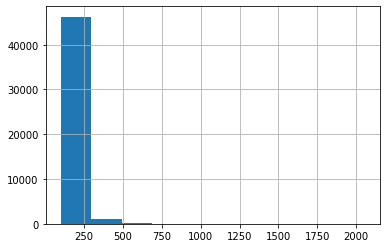

In [344]:
aviris_points_ch4.hist(bins = 12)
aviris_poly_ch4.hist(bins = 12)

When we execute the final data merge before running our regression models, we'll want to select some of the other features' observations according to the year and month for which we have AVIRIS-derived CH$_4$ estimates. To do that, we need the year and month corresponding to each observation in the response. We make that happen here by finding the column of the median $CH_4$ mean observation and matching it to the original AVIRIS raster's name, which contains the flight date.

In [339]:
def get_median_index(d):
    d = d.transpose()
    ranks = d.rank(pct=True)
    close_to_median = abs(ranks - 0.5)
    med_idx = close_to_median.idxmin()
    return med_idx

In [340]:
# get indices of medians for points
aviris_points_ch4_idx = pd.DataFrame({'aviris_col':get_median_index(aviris_points_mean)})
aviris_points_ch4_idx['aviris_col'] = [str(i) for i in aviris_points_ch4_idx['aviris_col']]

# get indices of medians for polygons
aviris_poly_ch4_idx = pd.DataFrame({'aviris_col':get_median_index(aviris_poly_mean)})
aviris_poly_ch4_idx['aviris_col'] = [str(i) for i in aviris_poly_ch4_idx['aviris_col']]

In [414]:
# load the list of filenames from the AVIRIS directory
flightpaths = pd.read_csv('Data/AVIRIS_Flightpath_Filenames.csv')
flightdates = [fid[16:24] for fid in list(aviris_points_mean.columns)]
datekey = pd.DataFrame({'aviris_col':aviris_points_mean.columns, 'date':flightdates})

In [ ]:
aviris_points_ch4_dates = aviris_points_ch4_idx.merge(datekey, how = 'left', on = 'aviris_col')
aviris_poly_ch4_dates = aviris_poly_ch4_idx.merge(datekey, how = 'left', on = 'aviris_col')

In [579]:
aviris_points_ch4_pxcounts = aviris_points_count.mean(axis = 1, skipna = True)
aviris_poly_ch4_pxcounts = aviris_points_count.mean(axis = 1, skipna = True)

Next, we create a final response dataframe by specifying the columns we want to preserve from the steps above and then merging the points and polygons dataframes.

In [387]:
aviris_points_base = aviris.loc[:,['Latitude', 'Longitude', 'Vista_IPCC', 'Vista_Name', 'Vista_SType',
       'Vista_ID', 'Vista_Date', 'State', 'City', 'Source', 'geometry']]
aviris_points_base['AVIRIS_CH4_median_ppmm'] = aviris_points_ch4
aviris_points_base['AVIRIS_CH4_median_date'] = aviris_points_ch4_dates['date']
aviris_points_base['AVIRIS_CH4_pxcount'] = aviris_points_ch4_pxcounts

In [777]:
aviris_base[aviris_base['AVIRIS_CH4_median_ppmm'].notna()].head(5)

,Latitude,Longitude,Vista_IPCC,Vista_Name,Vista_SType,Vista_ID,Vista_Date,State,City,Source,geometry,AVIRIS_CH4_median_ppmm,AVIRIS_CH4_median_date,AVIRIS_CH4_pxcount
17,37.861643,-120.939994,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001852,2019-11-10,CA,FARMINGTON,RAFIQ,"MULTIPOLYGON (((-82488.739 -16790.579, -82489....",152.003863,20160911,835.750000
29,34.901523,-117.151102,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001876,2019-11-10,CA,HINKLEY,RAFIQ,"MULTIPOLYGON (((260247.391 -342212.585, 260246...",111.881426,20160912,1670.000000
54,35.903687,-119.317296,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001759,2019-11-10,CA,EARLIMART,RAFIQ,"MULTIPOLYGON (((61647.033 -234595.348, 61646.1...",244.122330,20160912,3346.000000
57,35.994762,-119.497973,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001767,2019-11-10,CA,CORCORAN,RAFIQ,"MULTIPOLYGON (((45304.763 -224578.476, 45303.9...",112.788443,20160912,1114.666667
61,36.181868,-119.560789,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001776,2019-11-10,CA,HANFORD,RAFIQ,"MULTIPOLYGON (((39551.942 -203816.734, 39551.1...",105.410700,20160912,1216.272727


In [613]:
aviris_poly_base = aviris_poly.loc[:,['Latitude', 'Longitude', 'Vista_IPCC', 'Vista_Name', 'Vista_SType',
       'Vista_ID', 'Vista_Date', 'State', 'City', 'Source', 'geometry']]
aviris_poly_base['AVIRIS_CH4_median_ppmm'] = aviris_poly_ch4
aviris_poly_base['AVIRIS_CH4_median_date'] = aviris_poly_ch4_dates['date']
aviris_poly_base['AVIRIS_CH4_pxcount'] = aviris_poly_ch4_pxcounts

In [595]:
aviris_poly_base[aviris_poly_base['AVIRIS_CH4_median_ppmm'].notna()].head(5)

,Latitude,Longitude,Vista_IPCC,Vista_Name,Vista_SType,Vista_ID,Vista_Date,State,City,Source,geometry,AVIRIS_CH4_median_ppmm,AVIRIS_CH4_median_date,AVIRIS_CH4_pxcount
2,NaN,NaN,4B Biological Treatment of Solid Waste,Acme Composting Compost Facility,Composting Sites,CMP000003,2019-08-20,CA,Martinez,CalRecycle,"MULTIPOLYGON (((-187037.557 2247.982, -187020....",111.085646,20160910,4206.333333
23,NaN,NaN,4B Biological Treatment of Solid Waste,"Atlas Tree Service, Inc.",Composting Sites,CMP000024,2019-08-20,CA,Concord,CalRecycle,"MULTIPOLYGON (((-177591.083 2522.210, -177573....",316.934235,20160910,4208.000000


In [601]:
assert aviris_points_base.columns.all() == aviris_poly_base.columns.all()

In [765]:
aviris_ch4_all = pd.concat([aviris_base, aviris_poly_base], axis = 0, ignore_index = True)

In [946]:
aviris_ch4_all[aviris_ch4_all['AVIRIS_CH4_median_date'].notna()].head(5)

,Latitude,Longitude,Vista_IPCC,Vista_Name,Vista_SType,Vista_ID,Vista_Date,State,City,Source,geometry,AVIRIS_CH4_median_ppmm,AVIRIS_CH4_median_date,AVIRIS_CH4_pxcount,CH4_Mass_kg
17,37.861643,-120.939994,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001852,2019-11-10,CA,FARMINGTON,RAFIQ,"MULTIPOLYGON (((-82488.739 -16790.579, -82489....",152.003863,20160911,835.750000,0.000107
29,34.901523,-117.151102,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001876,2019-11-10,CA,HINKLEY,RAFIQ,"MULTIPOLYGON (((260247.391 -342212.585, 260246...",111.881426,20160912,1670.000000,0.000079
54,35.903687,-119.317296,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001759,2019-11-10,CA,EARLIMART,RAFIQ,"MULTIPOLYGON (((61647.033 -234595.348, 61646.1...",244.122330,20160912,3346.000000,0.000172
57,35.994762,-119.497973,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001767,2019-11-10,CA,CORCORAN,RAFIQ,"MULTIPOLYGON (((45304.763 -224578.476, 45303.9...",112.788443,20160912,1114.666667,0.000080
61,36.181868,-119.560789,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001776,2019-11-10,CA,HANFORD,RAFIQ,"MULTIPOLYGON (((39551.942 -203816.734, 39551.1...",105.410700,20160912,1216.272727,0.000074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234449,NaN,NaN,4D1 & 4D2 Domestic Wastewater Treatment and Di...,Delta Diablo S.D.,Wastewater Treatment Plant,WWT000027,2019-08-20,CA,Antioch,CARB,"MULTIPOLYGON (((-162518.517 1629.418, -162411....",154.098369,20160910,81837.000000,0.000109
234555,NaN,NaN,4D1 & 4D2 Domestic Wastewater Treatment and Di...,ORANGE COUNTY S.D. #2,Wastewater Treatment Plant,WWT000087,2019-08-20,CA,Huntington Beach,CARB,"MULTIPOLYGON (((189558.884 -483604.172, 189625...",133.962115,20170902,76859.333333,0.000095
234558,NaN,NaN,4D1 & 4D2 Domestic Wastewater Treatment and Di...,LACSD Valencia WRP,Wastewater Treatment Plant,WWT000060,2019-08-20,CA,Valencia,CARB,"MULTIPOLYGON (((129586.403 -397723.721, 129580...",107.186755,20171013,18890.911765,0.000076
234559,NaN,NaN,4D1 & 4D2 Domestic Wastewater Treatment and Di...,LACSD Joint WPCP,Wastewater Treatment Plant,WWT000059,2019-08-20,CA,Carson,CARB,"MULTIPOLYGON (((158451.241 -466745.518, 158445...",252.101421,20170902,107844.857143,0.000178


In [767]:
aviris_ch4_all[aviris_ch4_all['AVIRIS_CH4_median_ppmm'].notna()].head(5)

,Latitude,Longitude,Vista_IPCC,Vista_Name,Vista_SType,Vista_ID,Vista_Date,State,City,Source,geometry,AVIRIS_CH4_median_ppmm,AVIRIS_CH4_median_date,AVIRIS_CH4_pxcount
17,37.861643,-120.939994,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001852,2019-11-10,CA,FARMINGTON,RAFIQ,"MULTIPOLYGON (((-82488.739 -16790.579, -82489....",152.003863,20160911,835.750000
29,34.901523,-117.151102,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001876,2019-11-10,CA,HINKLEY,RAFIQ,"MULTIPOLYGON (((260247.391 -342212.585, 260246...",111.881426,20160912,1670.000000
54,35.903687,-119.317296,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001759,2019-11-10,CA,EARLIMART,RAFIQ,"MULTIPOLYGON (((61647.033 -234595.348, 61646.1...",244.122330,20160912,3346.000000
57,35.994762,-119.497973,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001767,2019-11-10,CA,CORCORAN,RAFIQ,"MULTIPOLYGON (((45304.763 -224578.476, 45303.9...",112.788443,20160912,1114.666667
61,36.181868,-119.560789,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001776,2019-11-10,CA,HANFORD,RAFIQ,"MULTIPOLYGON (((39551.942 -203816.734, 39551.1...",105.410700,20160912,1216.272727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234449,NaN,NaN,4D1 & 4D2 Domestic Wastewater Treatment and Di...,Delta Diablo S.D.,Wastewater Treatment Plant,WWT000027,2019-08-20,CA,Antioch,CARB,"MULTIPOLYGON (((-162518.517 1629.418, -162411....",154.098369,20160910,81837.000000
234555,NaN,NaN,4D1 & 4D2 Domestic Wastewater Treatment and Di...,ORANGE COUNTY S.D. #2,Wastewater Treatment Plant,WWT000087,2019-08-20,CA,Huntington Beach,CARB,"MULTIPOLYGON (((189558.884 -483604.172, 189625...",133.962115,20170902,76859.333333
234558,NaN,NaN,4D1 & 4D2 Domestic Wastewater Treatment and Di...,LACSD Valencia WRP,Wastewater Treatment Plant,WWT000060,2019-08-20,CA,Valencia,CARB,"MULTIPOLYGON (((129586.403 -397723.721, 129580...",107.186755,20171013,18890.911765
234559,NaN,NaN,4D1 & 4D2 Domestic Wastewater Treatment and Di...,LACSD Joint WPCP,Wastewater Treatment Plant,WWT000059,2019-08-20,CA,Carson,CARB,"MULTIPOLYGON (((158451.241 -466745.518, 158445...",252.101421,20170902,107844.857143


##### Step 5. 
Finally, we calculate an estimate of emitted CH$_4$ mass in the column above each point using the formula
$$IME = k \sum_{i=0}^{p}(a_i)(S_i)$$ 
where:
* $a_i$ = zonal mean CH$_4$ enhancement (ppm m),
* $S_i$ = area used to compute IME ($n$ pixels x 9m$^2$ pixel area [m$^2$])
* $k$ = a unit conversion to CH$_4$ mass (kg)

In [942]:
# calculate area
count = aviris_ch4_all['AVIRIS_CH4_pxcount']
area = count * 9 # m2

# calculate k
m = 16.04 # g CH4/mol
a = 22.71108 # L/mol of gas, assuming STP
vL = 1000 #L/m3
gkg = 1e-3
k = m * 1/a * 1/vc * gkg

# define IEM as median CH4 enhancement (ppm m)
iem = aviris_ch4_all['AVIRIS_CH4_median_ppmm']

# caculate mass
mass = iem * area * k

We added the mass estimate as a new column to the `aviris_ch4_all` geodataframe. This will later become our response variable. We exported the final dataframe as a geojson for subsequent merging with features.

In [943]:
aviris_ch4_all['CH4_Mass_kg'] = mass

## Data Summary and Exploratory Data Analysis (10 points)

## Forecasting and Prediction Modeling (25 points)

### Question 1: Predicting air quality measurements near methane emitter sources 
##### **To use as a feature for prediction questions 2 & 3**
We'd like to use air quality as a feature in our model; however, we don't have air quality measurements at the exact location of our emitter points. Therefore, we'll use K Nearest Neighbors to predict air quality at our emitter points, and use these predictions as a feature for our main prediction questions. 

#### Prepare data for model

First, we'll load in and take a look at our air quality data and the rest of our features/response. 

In [2]:
#Load data
airnow = gpd.read_file('Data/airnow_monthly_averages.json/airnow_monthly_averages.shp')
ch4 = gpd.read_file('Data/target_and_features.geojson')

In [3]:
#Check data
airnow.head()

,Latitude,Longitude,Parameter,Unit,Category,SiteName,AgencyName,FullAQSCod,IntlAQSCod,year,month,Value_mean,Value_coun,RawConcent,RawConce_1,AQI_mean,AQI_count,geometry
0,32.7355,-116.3454,PM10,UG/M3,0,Manzanita Tribe 1,Manzanita Band of the Kumeyaay Nation,60732000,840060732000,2016,1,-0.150000,2,0.000000,2,NaN,0,POINT (-116.34540 32.73550)
1,32.7355,-116.3454,PM10,UG/M3,1,Manzanita Tribe 1,Manzanita Band of the Kumeyaay Nation,60732000,840060732000,2016,1,2.933515,734,2.922131,732,2.750681,734,POINT (-116.34540 32.73550)
2,32.7355,-116.3454,PM10,UG/M3,1,Manzanita Tribe 1,Manzanita Band of the Kumeyaay Nation,60732000,840060732000,2016,2,5.725291,3440,5.867347,3430,5.306686,3440,POINT (-116.34540 32.73550)
3,32.7355,-116.3454,PM10,UG/M3,1,Manzanita Tribe 1,Manzanita Band of the Kumeyaay Nation,60732000,840060732000,2016,3,7.577446,2944,7.586957,2944,7.009511,2944,POINT (-116.34540 32.73550)
4,32.7355,-116.3454,PM10,UG/M3,1,Manzanita Tribe 1,Manzanita Band of the Kumeyaay Nation,60732000,840060732000,2016,4,11.366199,2139,11.404494,2136,10.531557,2139,POINT (-116.34540 32.73550)


In [4]:
airnow.shape

(17348, 18)

In [5]:
#Check data
ch4.head()

,Vista_ID,AVIRIS_CH4_median_ppmm,AVIRIS_CH4_median_date,AVIRIS_CH4_pxcount,CH4_Mass_kg,ng_pipelength_2,ng_pipelength_1000,ng_pipelength_5000,ng_pipelength_10000,ng_pipelength_50000,...,EmitterType_Refinery,EmitterType_Wastewater.Treatment.Plant,NearestNeighbor,NN_Distance_m,NN_Type,aviris_month,tropomi_no2_mean,tropomi_o3_mean,tropomi_so2_mean,geometry
0,DAF001852,152.003863,2016-09-11,835.750000,0.000107,6392.100707,7391.646636,16539.255266,57707.938406,667538.840773,...,0,0,DAF000658,2466.045452,Dairy,9,0.000031,2.750127,0.319865,"MULTIPOLYGON (((-82488.739 -16790.579, -82489...."
1,DAF001876,111.881426,2016-09-12,1670.000000,0.000079,85884.658642,94127.228727,127492.183922,170899.806844,842878.181010,...,0,0,COM000219,781.982522,Natural Gas Station,9,0.000033,2.709395,0.418704,"MULTIPOLYGON (((260247.391 -342212.585, 260246..."
2,DAF001759,244.122330,2016-09-12,3346.000000,0.000172,18873.827934,21161.291753,29954.305114,43939.178336,334243.882597,...,0,0,DAF000910,4638.269276,Dairy,9,0.000032,2.697235,0.341298,"MULTIPOLYGON (((61647.033 -234595.348, 61646.1..."
3,DAF001767,112.788443,2016-09-12,1114.666667,0.000080,0.000000,0.000000,0.000000,6753.570247,336951.983963,...,0,0,OGW166989,1181.976096,Oil and Gas Well,9,0.000032,2.698132,0.336061,"MULTIPOLYGON (((45304.763 -224578.476, 45303.9..."
4,DAF001776,105.410700,2016-09-12,1216.272727,0.000074,0.000000,0.000000,0.000000,0.000000,264800.590095,...,0,0,FDL000024,1901.175680,Feed Lot,9,0.000038,2.700418,0.342904,"MULTIPOLYGON (((39551.942 -203816.734, 39551.1..."


In [6]:
ch4.shape

(48386, 65)

As we saw in our EDA of our AirNow data, we have the fewest monitors for SO<sub>2</sub> and CO. This might lead to inaccurate predictions for these two parameters, since we have so few data to train on, and since our emitters will likely be located quite far from these few monitor locations. 

We can take a closer look to see what this will mean with regard to the number of observations for each of these parameters. 

In [7]:
#Let's see how many observations there are for each parameter
print(airnow[airnow['Parameter'] == 'PM2.5'].shape)
print(airnow[airnow['Parameter'] == 'PM10'].shape)
print(airnow[airnow['Parameter'] == 'OZONE'].shape)
print(airnow[airnow['Parameter'] == 'CO'].shape)
print(airnow[airnow['Parameter'] == 'NO2'].shape)
print(airnow[airnow['Parameter'] == 'SO2'].shape)

(4944, 18)
(2504, 18)
(7008, 18)
(952, 18)
(1550, 18)
(390, 18)


In [8]:
#Let's see how many measurements there for one year and month
print(airnow[(airnow['Parameter'] == 'CO') & (airnow['month'] == 10) & (airnow['year'] == 2016)].shape)
print(airnow[(airnow['Parameter'] == 'SO2') & (airnow['month'] == 10) & (airnow['year'] == 2016)].shape)
print(airnow[(airnow['Parameter'] == 'PM2.5') & (airnow['month'] == 10) & (airnow['year'] == 2016)].shape)
print(airnow[(airnow['Parameter'] == 'PM10') & (airnow['month'] == 10) & (airnow['year'] == 2016)].shape)
print(airnow[(airnow['Parameter'] == 'NO2') & (airnow['month'] == 10) & (airnow['year'] == 2016)].shape)
print(airnow[(airnow['Parameter'] == 'OZONE') & (airnow['month'] == 10) & (airnow['year'] == 2016)].shape)

(26, 18)
(13, 18)
(161, 18)
(107, 18)
(45, 18)
(316, 18)


For a given month/year, we only have 13 observations for SO<sub>2</sub> and 26 observations for CO. As such, our predictions for these two parameters could end up being quite meaningless, as they will likely be averaging measures that were taken from hundreds of miles away from each other. We'll drop these two parameters and focus on the other four for our KNN model. 

Next, we'll want to make sure that our datasets are in the same CRS. 

In [9]:
airnow.crs

{'init': 'epsg:4326'}

In [10]:
ch4.crs

{'init': 'epsg:4326'}

Our emitter data is showing the the CRS is WGS84, but we know this is not correct by looking at the geometries. We'll have to manually reset the CRS, which we know is in CA Albers from our other data cleaning. 

In [11]:
#Note: gpd is reading the incorrect CRS. Reset to CA Albers, NAD1983 meters
ch4.crs = {'init': 'epsg:3310'}

A projected CRS is preferred when calculating distances. We'll reproject our AirNow data to CA ALbers. 

In [12]:
#Since our CH4 emitter points are in the CA Albers projection, we'll need to change the CRS of our airnow dataframe
airnow = airnow.to_crs(epsg=3310)

/Users/michellesims/opt/anaconda3/envs/pp275/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


We can make sure that our two datasets line up by plotting the data. 

<AxesSubplot:>

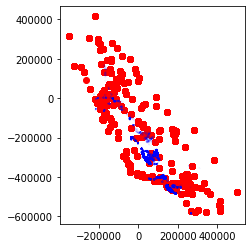

In [13]:
fig, ax = plt.subplots()
airnow.plot(ax = ax, color = 'red')
ch4.boundary.plot(ax = ax, color = 'blue')

The two datasets line up. 

Finally, we'll want to check the dates of our AVIRIS flights. These are the months we'll want want to use when fitting our model, since we want the AirNow monthly mean measurements to line up with the months of our AVIRIS flights. 

In [14]:
#check dates; these are the month/date combos we'll use in the predictions
ch4['AVIRIS_CH4_median_date'].unique()

array(['2016-09-11', '2016-09-12', '2016-09-13', '2016-09-14',
       '2016-09-15', '2016-09-16', '2016-09-17', '2016-09-10',
       '2016-09-22', '2016-09-25', '2016-09-30', '2016-10-01',
       '2016-09-19', '2016-10-03', '2016-10-08', '2016-10-05',
       '2016-10-06', '2016-10-11', '2016-10-25', '2016-10-29',
       '2016-11-03', '2017-03-09', '2017-06-15', '2016-10-26',
       '2017-06-16', '2016-11-04', '2016-11-02', '2017-06-18',
       '2017-06-20', '2017-08-30', '2017-08-31', '2017-09-01',
       '2017-09-05', '2017-09-06', '2017-09-07', '2017-09-08',
       '2017-09-09', '2017-09-10', '2017-09-13', '2017-09-15',
       '2017-09-16', '2017-09-11', '2017-09-20', '2017-09-26',
       '2017-09-28', '2017-06-17', '2017-10-05', '2017-09-30',
       '2017-06-19', '2017-10-06', '2017-10-07', '2017-10-10',
       '2017-09-02', '2017-10-12', '2017-10-03', '2017-10-13',
       '2017-09-18', '2017-10-16', '2017-10-23', '2017-09-19',
       '2017-10-24', '2017-09-25', '2017-09-22', '2017-

In [15]:
#Check columns
ch4.columns

Index(['Vista_ID', 'AVIRIS_CH4_median_ppmm', 'AVIRIS_CH4_median_date',
       'AVIRIS_CH4_pxcount', 'CH4_Mass_kg', 'ng_pipelength_2',
       'ng_pipelength_1000', 'ng_pipelength_5000', 'ng_pipelength_10000',
       'ng_pipelength_50000', 'weighted_cow_density', 'LULC_open_water_perc',
       'LULC_ice_snow_perc', 'LULC_developed_open_space_perc',
       'LULC_developed_low_int_perc', 'LULC_developed_med_int_perc',
       'LULC_developed_high_int_perc', 'LULC_barren_land_perc',
       'LULC_deciduous_forest_perc', 'LULC_evergreen_forest_perc',
       'LULC_mixed_forest_perc', 'LULC_shrub_scrub_perc',
       'LULC_grassland_herbaceous_perc', 'LULC_pasture_hay_perc',
       'LULC_cultivated_crops_perc', 'LULC_woody_wetlands_perc',
       'LULC_emergent_herbaceous_wetlands_perc', 'LULC_total_perc',
       'LULC_majority_class', 'LULC_Barren.Land', 'LULC_Cultivated.Crops',
       'LULC_Dev..Low.Int', 'LULC_Dev..Med.Int', 'LULC_Dev..Open.Space',
       'LULC_Evergreen.Forest', 'LULC_Grasslan

Finally, while we have a column called `aviris_month` for the month the AVIRIS flight was taken, we'll want a column for the year, as this will make it easier to subset our data for the model. 

In [16]:
#add column for aviris_year
ch4['aviris_year'] = 0

for i in range(len(ch4)):
    s = ch4['AVIRIS_CH4_median_date'][i]
    ch4.loc[i,'aviris_year']= int(s[0:4])

#### KNN Model

Because the variation in air quality measurements between locations might vary by month and year (due to wildfires and other events that might impact air quality), we'll want to subset our data by month, year, and parameter before training our model. In other words, we want to fit a model using the measurements for a given parameter, month, and year, and then use that model to predict the air quality measurement at our emitter locations for that same month and year. 

For our model, we'll use `scikitlearn`'s KNN regression, which is used for continuous data, and is computed based on the mean of the K Nearest Neighbors. Because `scikitlearn`'s KNN regression finds the nearest neighbor in **feature space**, and our goal is to find the nearest neighbor in **physical space**, we will train our model with only the lat/lon coordinates, so that the model is finding the nearest neighbor in physical space. 

The hyperparameter we'll want to test is the k value that gives us the lowest error, as measured by Root Mean Squared Error. We can us `scikitlearn`'s `GridSearchCV` to find the optimal k value for each month/year/parameter combo. Another parameter that we can test for KNN regression is `weights`: scikitlearn gives us the option to specify the weight function used in prediction; either uniform weights, or inverse distance weighting. 

Below, we'll create a function where we input the AirNow dataframe, parameter, year, month, and an array of K values, and we'll use `scikitlearn` to fit the model and return the model (which we can then use to predict the air quality measurements at the emitter location for that month, year, and parameter), the parameter specifications, and the Root Mean Squared Error (RMSE). Note: `GridSearchCV` allows us to specify which scoring parameter we'd like to use. Since it follows the convention that higher return values are better than lower return values, MSE & RMSE are available as negated values, which is why these values will be negative. 

We'll use **Kfold cross validation with 10 folds** to test the performance of our model, following convention (note: we tried 5 folds as well, and did not see a significant change in the performance of our model). Since we are not testing between different types of models, just tuning the hyperparameters, we will not set aside a separate test set. 

For our **K values**, we'll try an array of 1-10. We will not go higher than 10, because we know based on our EDA that the AirNow monitors are not located too close to each other; therefore, if we average more than 10, we're covering a very large area of California! We want to restrain the model so that it's not averaging air quality measurements over too large a portion of the state, otherwise our prediction becomes meaningless and many of our predictions will end up taking the same value. 

In [17]:
#Define a function to train the model and find the optimal hyperparameters. 

def KNN(df, parameter, year, month, k):
    """Fits a KNN model for a specific air quality parameter, averaged over a given month, in a given year. 
    Arguments:
        dataframe: the Air Now dataframe. 
        parameter (string): Air quality measurement parameter: PM10, OZONE, PM2.5, CO, NO2, SO2
        year: year to use to fit model, 2016 or 2017
        month: month to use to fit model (1-12)
        k: an array of k values to test for fitting model
    Returns:
        model: the trained model
        opt_k: the optimal k value
        opt_score: the mean MSE of the optimal k value
        """
    
    #Filter data to month, year, and parameter
    data = df[(df['Parameter'] == parameter) & (df['year'] == year) & (df['month'] == month)]
    lat = data.geometry.y
    lon  = data.geometry.x
    X = pd.DataFrame({'lat': lat, 'lon': lon})
    y = data['Value_mean']
    
    #knn model object
    knn = KNeighborsRegressor()
    
    #create dictionary of parameter values
    param_grid = {'n_neighbors': k, 'weights': ['uniform', 'distance']}
    
    #specify hyperparameters
    knn_cv = GridSearchCV(knn, param_grid, scoring = 'neg_root_mean_squared_error', cv = 10)
    
    #fit model
    model = knn_cv.fit(X,y)
    
    return model, model.best_params_, model.best_score_
    

For our methane emitters, we have data from the following dates: Sept, Oct, and Nov 2016, & March, June, Aug, Sept, Oct, & Nov 2017. Let's fit a model and see how our KNN model performs for each of these year/month combinations. 

In [18]:
#Set up parameters to run through the loop
parameters = ['PM10', 'OZONE', 'PM2.5', 'NO2'] #Remove SO2 & CO since there are so few values
dates = np.array([[9, 2016], [10, 2016], [11, 2016], [3, 2017], [6, 2017], [8, 2017], [9, 2017], [10, 2017], [11, 2017]])

In [19]:
#Run through loop for to fit model each date/time/parameter combo
RMSE_array = np.zeros((4, 9))
for i in range(len(parameters)):
    for j in range(len(dates)):
        _, params, RMSE = KNN(airnow, parameters[i], dates[j, 1], dates[j, 0], np.arange(1, 11))
        print(str(dates[j, 0]) + '/' + str(dates[j, 1]) + ' ' + str(parameters[i]) + ' parameters:', params)
        print(str(dates[j, 0]) + '/' + str(dates[j, 1]) + ' ' + str(parameters[i]) + ' RMSE:', RMSE)  
        RMSE_array[i, j] = RMSE

9/2016 PM10 parameters: {'n_neighbors': 6, 'weights': 'uniform'}
9/2016 PM10 RMSE: -44.94134313586436
10/2016 PM10 parameters: {'n_neighbors': 9, 'weights': 'uniform'}
10/2016 PM10 RMSE: -115.61168042715697
11/2016 PM10 parameters: {'n_neighbors': 10, 'weights': 'distance'}
11/2016 PM10 RMSE: -101.96174176110728
3/2017 PM10 parameters: {'n_neighbors': 9, 'weights': 'uniform'}
3/2017 PM10 RMSE: -186.6893641953879
6/2017 PM10 parameters: {'n_neighbors': 10, 'weights': 'uniform'}
6/2017 PM10 RMSE: -25.78616320329217
8/2017 PM10 parameters: {'n_neighbors': 10, 'weights': 'uniform'}
8/2017 PM10 RMSE: -23.99469161265189
9/2017 PM10 parameters: {'n_neighbors': 10, 'weights': 'uniform'}
9/2017 PM10 RMSE: -113.5316094895948
10/2017 PM10 parameters: {'n_neighbors': 3, 'weights': 'uniform'}
10/2017 PM10 RMSE: -106.70685916665772
11/2017 PM10 parameters: {'n_neighbors': 8, 'weights': 'uniform'}
11/2017 PM10 RMSE: -135.45521801580122
9/2016 OZONE parameters: {'n_neighbors': 6, 'weights': 'uniform'}

Interestingly, most of our models took the uniform weight. Most of our K values took on a value on the higher end, although they varied widely! 

To visualize how our model performed, we'll plot the RMSEs. 

<ipython-input-20-c32efe0ccda1>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, '9/16', '10/16', '11/16', '3/17', '6/17', '8/17', '9/17', '10/17', '11/17'])


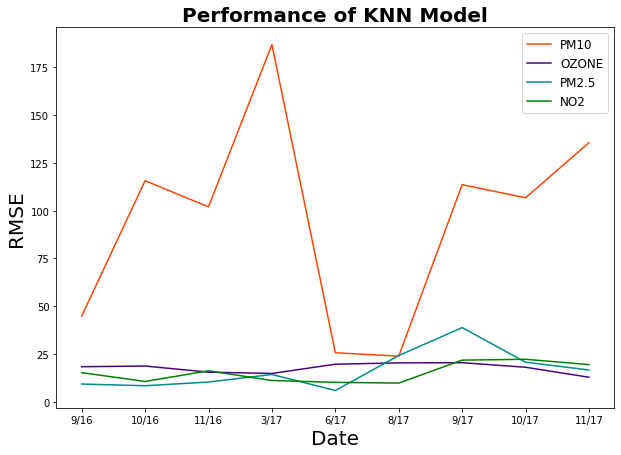

In [20]:
#Plot RMSEs
fig, ax = plt.subplots(figsize = (10, 7))
plt.title('Performance of KNN Model', size = 20, fontweight = 'bold')
plt.ylabel('RMSE', size = 20)
plt.xlabel('Date', size = 20)
ax.plot(np.arange(1,10), abs(RMSE_array[0, :]), label = 'PM10', color = 'orangered')
ax.plot(np.arange(1,10), abs(RMSE_array[1,:]), label = 'OZONE', color = 'indigo')
ax.plot(np.arange(1,10), abs(RMSE_array[2,:]), label = 'PM2.5', color = 'darkcyan')
ax.plot(np.arange(1,10), abs(RMSE_array[3,:]), label = 'NO2', color = 'green')
ax.set_xticklabels([0, '9/16', '10/16', '11/16', '3/17', '6/17', '8/17', '9/17', '10/17', '11/17'])
plt.legend(fontsize = 'large')

While our Ozone, NO<sub>2</sub>, and PM2.5 model seemed to perform within a consistent range, our PM10 model performance varied widely! This is likely because PM10 settles quickly compared to PM2.5, leading to wider variation in measurements. 

Since our air quality measures are in different units, we'll separate our parameters by those that are measured in the same units to better understand the RMSE: PM2.5 & PM10 (ug/m<sup>3</sup>) and NO<sub>2</sub> and Ozone (ppb).

<ipython-input-21-9d3a52caf71a>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([0, '9/16', '10/16', '11/16', '3/17', '6/17', '8/17', '9/17', '10/17', '11/17'])
<ipython-input-21-9d3a52caf71a>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([0, '9/16', '10/16', '11/16', '3/17', '6/17', '8/17', '9/17', '10/17', '11/17'])


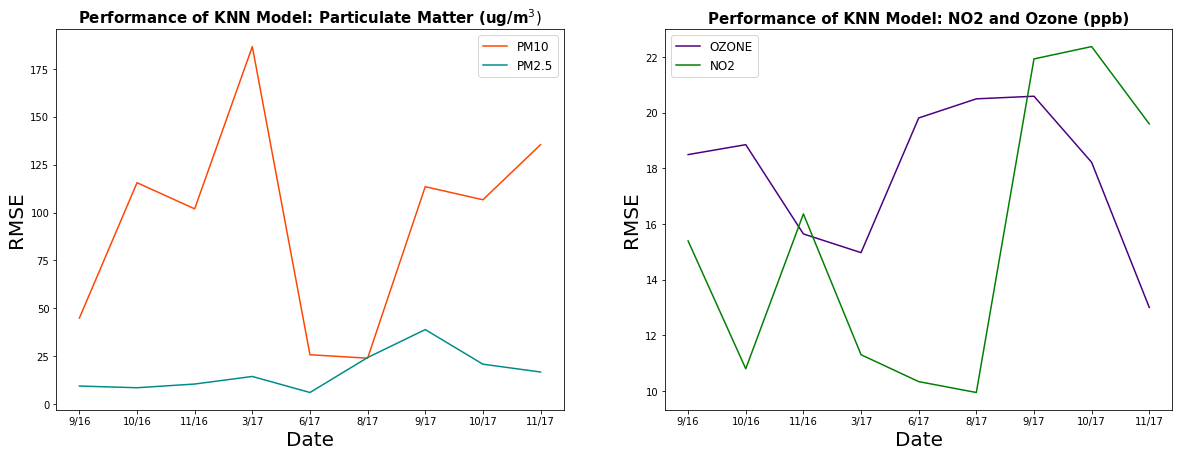

In [21]:
#Plot RMSEs
fig, ax = plt.subplots(ncols = 2, figsize = (20, 7))
ax[0].set_title('Performance of KNN Model: Particulate Matter (ug/m$^{3})$', size = 15, fontweight = 'bold')
ax[0].set_ylabel('RMSE', size = 20)
ax[0].set_xlabel('Date', size = 20)
ax[0].plot(np.arange(1,10), abs(RMSE_array[0, :]), label = 'PM10', color = 'orangered')
ax[0].plot(np.arange(1,10), abs(RMSE_array[2,:]), label = 'PM2.5', color = 'darkcyan')
ax[0].set_xticklabels([0, '9/16', '10/16', '11/16', '3/17', '6/17', '8/17', '9/17', '10/17', '11/17'])
ax[0].legend(fontsize = 'large')

ax[1].set_title('Performance of KNN Model: NO2 and Ozone (ppb)', size = 15, fontweight = 'bold')
ax[1].set_ylabel('RMSE', size = 20)
ax[1].set_xlabel('Date', size = 20)
ax[1].plot(np.arange(1,10), abs(RMSE_array[1,:]), label = 'OZONE', color = 'indigo')
ax[1].plot(np.arange(1,10), abs(RMSE_array[3,:]), label = 'NO2', color = 'green')
ax[1].set_xticklabels([0, '9/16', '10/16', '11/16', '3/17', '6/17', '8/17', '9/17', '10/17', '11/17'])
ax[1].legend(fontsize = 'large')

From this graph, we can better disaggregate the performances of our various models. The RMSE for NO<sub>2</sub> and Ozone varied between 10-22. The RMSE for PM2.5 varied between 6-38, and as discussed above, the RMSE for PM10 varied widely. 

Given the limited number of AirNow sensors located throughout the state of California (and thus limits to the level of accuracy we can expect from this model, as it will have to average predictions from a wider area than we would ideally like), we consider this a reasonable performance and will include the predictions from these KNN models as features in our subsequent models. 

Now, that we've taken a look at how the model performs, we'll create a function to use the fitted optimal model for any given month/year/parameter to predict that air quality parameter value for the corresponding month/year of each observation in our dataset, using the latitudes and longitudes of the emitter points. We'll append this prediction as a column with the predicted values. 

In [22]:
def predict_AQ(airnow, emitter, parameter, dates, k):
    """Fits a KNN model for a specific air quality parameter averaged over a given month, in a given year. 
    Uses that model to predict the air quality measure at the emitter point location in that month and year 
    and appends the prediction to the dataframe.
    Arguments:
        airnow: the Air Now dataframe. 
        emitter: the methane emitter dataframe
        parameter: an nd.array of air quality measurement parameters: PM10, OZONE, PM2.5, NO2
        dates: an 2darray of the month/year combos to fit; the year/month combos that appear in the emitter dataset.
            Should follow format [month (1-12), year (2016 or 2017)]
        k: an array of k values to test for fitting model
    Returns:
        model: the trained model
        opt_k: the optimal k value
        opt_score: the mean MSE of the optimal k value
        """
    
    #add column to store predicted air quality measure
    for z in range(len(parameter)):
        emitter[parameter[z]] = 0
    
        #Fit model & get prediction for every year/month combo 
        for i in range(len(dates)): 
            #fit the model for each month/date combo in dates
            model, _, _ = KNN(airnow, parameter[z], dates[i, 1], dates[i, 0], np.arange(1, 11)) 
            #For any corresponding observations with that same date/month combo, predict the air quality value and append
            for j in range(len(emitter)):
                if (emitter['aviris_month'][j] == dates[i,0]) & (emitter['aviris_year'][j] == dates[i,1]):
                    X = np.array([emitter['geometry'][j].centroid.y, emitter['geometry'][j].centroid.x]).reshape(1,-1)
                    y_pred = model.predict(X)
                    emitter.loc[j, parameter[z]] = y_pred
    
    return emitter

In [23]:
gdf = predict_AQ(airnow, ch4, parameters, dates, np.arange(1,11))

In [24]:
gdf.head()

,Vista_ID,AVIRIS_CH4_median_ppmm,AVIRIS_CH4_median_date,AVIRIS_CH4_pxcount,CH4_Mass_kg,ng_pipelength_2,ng_pipelength_1000,ng_pipelength_5000,ng_pipelength_10000,ng_pipelength_50000,...,aviris_month,tropomi_no2_mean,tropomi_o3_mean,tropomi_so2_mean,geometry,aviris_year,PM10,OZONE,PM2.5,NO2
0,DAF001852,152.003863,2016-09-11,835.750000,0.000107,6392.100707,7391.646636,16539.255266,57707.938406,667538.840773,...,9,0.000031,2.750127,0.319865,"MULTIPOLYGON (((-82488.739 -16790.579, -82489....",2016,51.724377,54.575650,12.110008,12.352775
1,DAF001876,111.881426,2016-09-12,1670.000000,0.000079,85884.658642,94127.228727,127492.183922,170899.806844,842878.181010,...,9,0.000033,2.709395,0.418704,"MULTIPOLYGON (((260247.391 -342212.585, 260246...",2016,123.754870,54.635442,12.016291,17.446938
2,DAF001759,244.122330,2016-09-12,3346.000000,0.000172,18873.827934,21161.291753,29954.305114,43939.178336,334243.882597,...,9,0.000032,2.697235,0.341298,"MULTIPOLYGON (((61647.033 -234595.348, 61646.1...",2016,122.085898,58.867722,12.210585,17.895675
3,DAF001767,112.788443,2016-09-12,1114.666667,0.000080,0.000000,0.000000,0.000000,6753.570247,336951.983963,...,9,0.000032,2.698132,0.336061,"MULTIPOLYGON (((45304.763 -224578.476, 45303.9...",2016,101.719890,54.932985,13.713212,23.538732
4,DAF001776,105.410700,2016-09-12,1216.272727,0.000074,0.000000,0.000000,0.000000,0.000000,264800.590095,...,9,0.000038,2.700418,0.342904,"MULTIPOLYGON (((39551.942 -203816.734, 39551.1...",2016,101.719890,54.932985,13.713212,23.313427


To see our predictions, we'll plot a histogram of each parameter. 

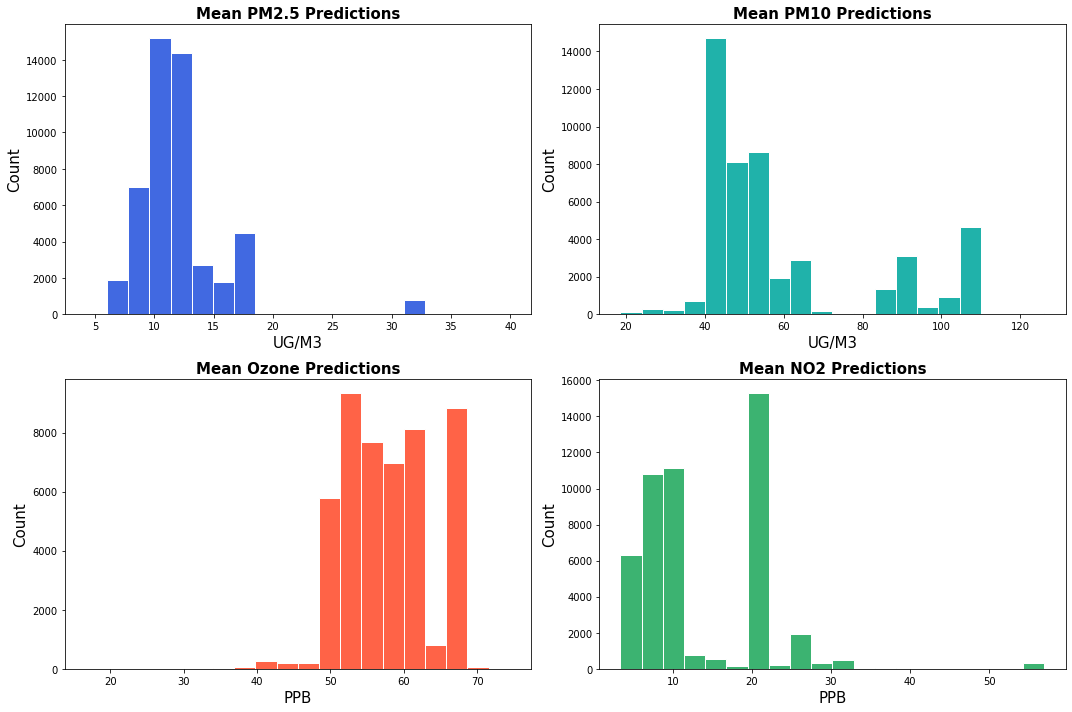

In [25]:
#Plot predicted values
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (15, 10))
ax[0,0].hist(gdf['PM2.5'], edgecolor = 'white', color = 'royalblue', bins = 20)
ax[0,0].set_xlabel('UG/M3', size = 15)
ax[0,0].set_ylabel('Count', size = 15)
ax[0,0].set_title('Mean PM2.5 Predictions', fontweight = 'bold', size = 15)

ax[0,1].hist(gdf['PM10'], edgecolor = 'white', color = 'lightseagreen', bins = 20)
ax[0,1].set_xlabel('UG/M3', size = 15)
ax[0,1].set_ylabel('Count', size = 15)
ax[0,1].set_title('Mean PM10 Predictions', fontweight = 'bold', size = 15)

ax[1,0].hist(gdf['OZONE'], edgecolor = 'white', color = 'tomato', bins = 20)
ax[1,0].set_xlabel('PPB', size = 15)
ax[1,0].set_ylabel('Count', size = 15)
ax[1,0].set_title('Mean Ozone Predictions', fontweight = 'bold', size = 15)

ax[1,1].hist(gdf['NO2'], edgecolor = 'white', color = 'mediumseagreen', bins = 20)
ax[1,1].set_xlabel('PPB', size = 15)
ax[1,1].set_ylabel('Count', size = 15)
ax[1,1].set_title('Mean NO2 Predictions', fontweight = 'bold', size = 15)
plt.tight_layout()

We can also see how these histograms compare with the AirNow values. 

In [26]:
#Filter AirNow for months that we used in our models
plot = airnow[(airnow['month'] == 3) | (airnow['month'] == 6) | 
       (airnow['month'] == 9) | (airnow['month'] == 10) | 
      (airnow['month'] == 11) | (airnow['month'] == 8)]

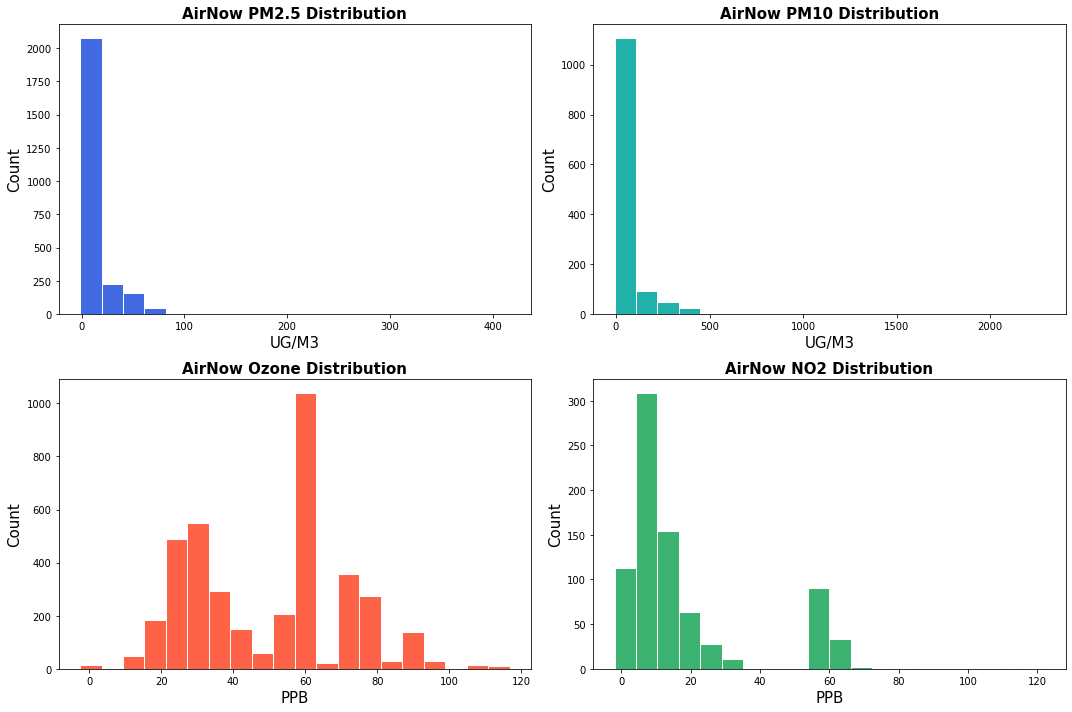

In [27]:
#Plot AirNow distribution
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (15, 10))
ax[0,0].hist(plot[plot['Parameter'] == 'PM2.5']['Value_mean'], edgecolor = 'white', color = 'royalblue', bins = 20)
ax[0,0].set_xlabel('UG/M3', size = 15)
ax[0,0].set_ylabel('Count', size = 15)
ax[0,0].set_title('AirNow PM2.5 Distribution', fontweight = 'bold', size = 15)

ax[0,1].hist(plot[plot['Parameter'] == 'PM10']['Value_mean'], edgecolor = 'white', color = 'lightseagreen', bins = 20)
ax[0,1].set_xlabel('UG/M3', size = 15)
ax[0,1].set_ylabel('Count', size = 15)
ax[0,1].set_title('AirNow PM10 Distribution', fontweight = 'bold', size = 15)

ax[1,0].hist(plot[plot['Parameter'] == 'OZONE']['Value_mean'], edgecolor = 'white', color = 'tomato', bins = 20)
ax[1,0].set_xlabel('PPB', size = 15)
ax[1,0].set_ylabel('Count', size = 15)
ax[1,0].set_title('AirNow Ozone Distribution', fontweight = 'bold', size = 15)

ax[1,1].hist(plot[plot['Parameter'] == 'NO2']['Value_mean'], edgecolor = 'white', color = 'mediumseagreen', bins = 20)
ax[1,1].set_xlabel('PPB', size = 15)
ax[1,1].set_ylabel('Count', size = 15)
ax[1,1].set_title('AirNow NO2 Distribution', fontweight = 'bold', size = 15)
plt.tight_layout()

Comparing the AirNow histograms to our predictions shows that given the AirNow measurements, our predictions seem reasonable. 

Finally, we're also interested in seeing how the Ozone and NO<sub>2</sub> measures correlate with our Tropomi measures. 

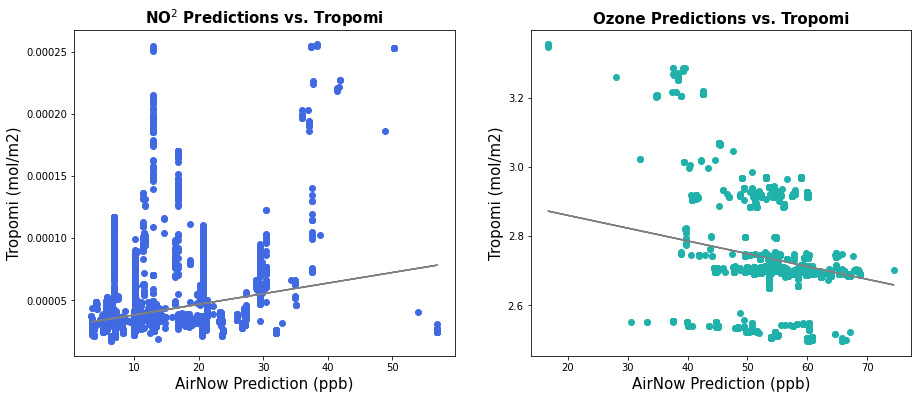

In [29]:
#Plot AirNow predictions vs. Tropomi
fig, ax = plt.subplots(ncols = 2, figsize = (15, 6))
ax[0].scatter(gdf['NO2'], gdf['tropomi_no2_mean'], color = 'royalblue')
ax[0].set_xlabel('AirNow Prediction (ppb)', size = 15)
ax[0].set_ylabel('Tropomi (mol/m2)', size = 15)
ax[0].set_title('NO$^{2}$ Predictions vs. Tropomi', fontweight = 'bold', size = 15)
z = np.polyfit(gdf['NO2'], gdf['tropomi_no2_mean'], 1)
p = np.poly1d(z)
ax[0].plot(gdf['NO2'], p(gdf['NO2']), color = 'gray')

ax[1].scatter(gdf['OZONE'], gdf['tropomi_o3_mean'], color = 'lightseagreen')
ax[1].set_xlabel('AirNow Prediction (ppb)', size = 15)
ax[1].set_ylabel('Tropomi (mol/m2)', size = 15)
ax[1].set_title('Ozone Predictions vs. Tropomi', fontweight = 'bold', size = 15)
z = np.polyfit(gdf['OZONE'], gdf['tropomi_o3_mean'], 1)
p = np.poly1d(z)
ax[1].plot(gdf['OZONE'], p(gdf['OZONE']), color = 'gray')

There seems to be a very slight positive correlation between Tropomi mol/m<sup>2</sup> and AirNow prediction ppb, which is what we would expect to see. The negative correlation between Tropomi Ozone mol/m<sup>2</sup> and the AirNow prediction is unexpected; we would expect to see a positive correlation.  However, since Ozone can be formed from other compounds more readily, it is less stable in the atmosphere, which could explain why we don't see these results.

We are now ready to move on to our other prediction questions. 

### Question 2: Predicting ground-level methane emissions throughout California

With the lack of facility level measurements, air monitor network sensors, and regulation of methane in the United States, it was imperative to develop a model that could predict ground measurements of CH<sub>4</sub>. Using studies like the Novotony et al. (2011) as a basis, we decided to go about this prediction using OLS, Lasso, and Ridge.

#### Overview of our dataset

First let's double check our geodataframe.

In [30]:
gdf.shape

(48386, 70)

In [31]:
gdf.head()

,Vista_ID,AVIRIS_CH4_median_ppmm,AVIRIS_CH4_median_date,AVIRIS_CH4_pxcount,CH4_Mass_kg,ng_pipelength_2,ng_pipelength_1000,ng_pipelength_5000,ng_pipelength_10000,ng_pipelength_50000,...,aviris_month,tropomi_no2_mean,tropomi_o3_mean,tropomi_so2_mean,geometry,aviris_year,PM10,OZONE,PM2.5,NO2
0,DAF001852,152.003863,2016-09-11,835.750000,0.000107,6392.100707,7391.646636,16539.255266,57707.938406,667538.840773,...,9,0.000031,2.750127,0.319865,"MULTIPOLYGON (((-82488.739 -16790.579, -82489....",2016,51.724377,54.575650,12.110008,12.352775
1,DAF001876,111.881426,2016-09-12,1670.000000,0.000079,85884.658642,94127.228727,127492.183922,170899.806844,842878.181010,...,9,0.000033,2.709395,0.418704,"MULTIPOLYGON (((260247.391 -342212.585, 260246...",2016,123.754870,54.635442,12.016291,17.446938
2,DAF001759,244.122330,2016-09-12,3346.000000,0.000172,18873.827934,21161.291753,29954.305114,43939.178336,334243.882597,...,9,0.000032,2.697235,0.341298,"MULTIPOLYGON (((61647.033 -234595.348, 61646.1...",2016,122.085898,58.867722,12.210585,17.895675
3,DAF001767,112.788443,2016-09-12,1114.666667,0.000080,0.000000,0.000000,0.000000,6753.570247,336951.983963,...,9,0.000032,2.698132,0.336061,"MULTIPOLYGON (((45304.763 -224578.476, 45303.9...",2016,101.719890,54.932985,13.713212,23.538732
4,DAF001776,105.410700,2016-09-12,1216.272727,0.000074,0.000000,0.000000,0.000000,0.000000,264800.590095,...,9,0.000038,2.700418,0.342904,"MULTIPOLYGON (((39551.942 -203816.734, 39551.1...",2016,101.719890,54.932985,13.713212,23.313427


In [32]:
gdf.columns

Index(['Vista_ID', 'AVIRIS_CH4_median_ppmm', 'AVIRIS_CH4_median_date',
       'AVIRIS_CH4_pxcount', 'CH4_Mass_kg', 'ng_pipelength_2',
       'ng_pipelength_1000', 'ng_pipelength_5000', 'ng_pipelength_10000',
       'ng_pipelength_50000', 'weighted_cow_density', 'LULC_open_water_perc',
       'LULC_ice_snow_perc', 'LULC_developed_open_space_perc',
       'LULC_developed_low_int_perc', 'LULC_developed_med_int_perc',
       'LULC_developed_high_int_perc', 'LULC_barren_land_perc',
       'LULC_deciduous_forest_perc', 'LULC_evergreen_forest_perc',
       'LULC_mixed_forest_perc', 'LULC_shrub_scrub_perc',
       'LULC_grassland_herbaceous_perc', 'LULC_pasture_hay_perc',
       'LULC_cultivated_crops_perc', 'LULC_woody_wetlands_perc',
       'LULC_emergent_herbaceous_wetlands_perc', 'LULC_total_perc',
       'LULC_majority_class', 'LULC_Barren.Land', 'LULC_Cultivated.Crops',
       'LULC_Dev..Low.Int', 'LULC_Dev..Med.Int', 'LULC_Dev..Open.Space',
       'LULC_Evergreen.Forest', 'LULC_Grasslan

Before we dive into dividing up our data into features and our y variable, let's double check our variables like looking at our summary statistics.

In [33]:
columns_of_interest = np.setdiff1d(list(gdf.columns),['Vista_ID', 'aviris_month','aviris_year','geometry'])

for column in columns_of_interest:
    print(gdf[column].describe())

count          48386
unique            68
top       2017-10-06
freq            6814
Name: AVIRIS_CH4_median_date, dtype: object
count    48386.000000
mean       156.687343
std         64.226277
min        100.001778
25%        118.497591
50%        139.909142
75%        175.603822
max       2057.326458
Name: AVIRIS_CH4_median_ppmm, dtype: float64
count    4.838200e+04
mean     1.599713e+03
std      1.467527e+04
min      1.989163e-06
25%      6.960505e+02
50%      1.025500e+03
75%      1.381344e+03
max      1.956112e+06
Name: AVIRIS_CH4_pxcount, dtype: float64
count    48386.000000
mean         0.000111
std          0.000045
min          0.000071
25%          0.000084
50%          0.000099
75%          0.000124
max          0.001453
Name: CH4_Mass_kg, dtype: float64
count    48386.000000
mean         0.000517
std          0.022725
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: EmitterType_Composting.Sites, dtype: float

count    48386.000000
mean         0.433615
std          0.258420
min          0.000004
25%          0.322968
50%          0.481612
75%          0.646432
max          0.965636
Name: LULC_grassland_herbaceous_perc, dtype: float64
count    48386.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: LULC_ice_snow_perc, dtype: float64
count         48386
unique            7
top       Grassland
freq          35709
Name: LULC_majority_class, dtype: object
count    48386.000000
mean         0.000568
std          0.004151
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000018
max          0.306679
Name: LULC_mixed_forest_perc, dtype: float64
count    48386.000000
mean         0.043870
std          0.103629
min          0.000000
25%          0.000803
50%          0.002237
75%          0.005665
max          0.633973
Name: LULC_open_water_perc, dtype: float64
count    48386.000000
mean       

Most of our variables aren't objects, but a few are. We'll make sure to note which ones these are and then exclude them from being features.

In [34]:
gdf.select_dtypes(include='object').head()

,Vista_ID,AVIRIS_CH4_median_date,LULC_majority_class,NearestNeighbor,NN_Type
0,DAF001852,2016-09-11,Cultivated Crops,DAF000658,Dairy
1,DAF001876,2016-09-12,Shrub Scrub,COM000219,Natural Gas Station
2,DAF001759,2016-09-12,Cultivated Crops,DAF000910,Dairy
3,DAF001767,2016-09-12,Cultivated Crops,OGW166989,Oil and Gas Well
4,DAF001776,2016-09-12,Cultivated Crops,FDL000024,Feed Lot


We also have some hot encoded variables that are just 0s. We can omit those.

In [35]:
columns_of_interest = np.setdiff1d(list(gdf.columns),['Vista_ID', 'aviris_month','aviris_year','geometry'])

vars_0 = [column for column in columns_of_interest if len(gdf[column].unique())==1 and gdf[column].unique()==0]
print(vars_0)

['LULC_Barren.Land', 'LULC_Dev..Open.Space', 'LULC_Evergreen.Forest', 'LULC_Herbaceous.Wetlands', 'LULC_Pasture.Hay', 'LULC_ice_snow_perc']


Our data is comprised of features from various sources. These can be categorized on whether they are categorical or quantitative, which you will find in the following table.


| Response Variable | Quantitative Feature | Categorical Feature |
| --- | --- | --- |
|`CH4_Mass_kg`|`ng_pipelength_2`|`LULC_Cultivated.Crops`|
||`ng_pipelength_1000`|`LULC_Dev..Low.Int`|
||`ng_pipelength_5000`|`LULC_Dev..Med.Int`|
||`ng_pipelength_10000`|`LULC_Grassland`|
||`ng_pipelength_50000`|`LULC_Open.Water`|
||`weighted_cow_density`|`LULC_Shrub.Scrub`|
||`LULC_open_water_perc`|`LULC_Mixed.Forest`|
||`LULC_developed_open_space_perc`|`EmitterType_Composting.Sites`|
||`LULC_developed_low_int_perc`|`EmitterType_Compressed.Natural.Gas.Fueling.Station`|
||`LULC_developed_med_int_perc`|`EmitterType_Dairy`|
||`LULC_developed_high_int_perc`|`EmitterType_Digester`|
||`LULC_barren_land_perc`|`EmitterType_Feed.Lot`|
||`LULC_deciduous_forest_perc`|`EmitterType_Landfill`|
||`LULC_evergreen_forest_perc`|`EmitterType_Liquefied.Natural.Gas.Fueling.Station`|
||`LULC_mixed_forest_perc`|`EmitterType_Natural.Gas.Processing.Plants`|
||`LULC_shrub_scrub_perc`|`EmitterType_Natural.Gas.Station`|
||`LULC_grassland_herbaceous_perc`|`EmitterType_Natural.Gas.Storage.Field`|
||`LULC_pasture_hay_perc`|`EmitterType_Oil.and.Gas.Facility.Boundary`|
||`LULC_cultivated_crops_perc`|`EmitterType_Oil.and.Gas.Field.Boundary`|
||`LULC_woody_wetlands_perc`|`EmitterType_Oil.and.Gas.Well`|
||`LULC_emergent_herbaceous_wetlands_perc`|`EmitterType_Power.Plant`|
||`LULC_total_perc`|`EmitterType_Refinery`|
||`NN_Distance_m`|`EmitterType_Wastewater.Treatment.Plant`|
||`tropomi_no2_mean`|
||`tropomi_o3_mean`
||`tropomi_so2_mean`|
||`PM2.5`|
||`PM10`|
||`OZONE`|
||`NO2`|

We'll double check if any of our rows have missing values.

In [36]:
np.sum(gdf.isna(),axis=1).value_counts()

0    48382
1        4
dtype: int64

It seems that the maximum value of missing values for a single row is 1. Let's see what variable may be the root of this.

In [37]:
np.sum(gdf.isna(),axis=0).sort_values(ascending=False)[:10]

AVIRIS_CH4_pxcount                        4
NO2                                       0
LULC_woody_wetlands_perc                  0
LULC_evergreen_forest_perc                0
LULC_mixed_forest_perc                    0
LULC_shrub_scrub_perc                     0
LULC_grassland_herbaceous_perc            0
LULC_pasture_hay_perc                     0
LULC_cultivated_crops_perc                0
LULC_emergent_herbaceous_wetlands_perc    0
dtype: int64

Since the pixel count is not a feature, we can ignore this and say that our data is complete to conduct our prediction.

Finally, we're interested in seeing how the CH4 emissions vary by feature type. We'll plot a histogram of emissions level by each emitter type. Before running our model. 

In [38]:
#Get columns for emitter type
col_emitter_type = [col for col in gdf if col.startswith('Emitter')]
print(col_emitter_type)

['EmitterType_Composting.Sites', 'EmitterType_Compressed.Natural.Gas.Fueling.Station', 'EmitterType_Dairy', 'EmitterType_Digester', 'EmitterType_Feed.Lot', 'EmitterType_Landfill', 'EmitterType_Liquefied.Natural.Gas.Fueling.Station', 'EmitterType_Natural.Gas.Processing.Plants', 'EmitterType_Natural.Gas.Station', 'EmitterType_Natural.Gas.Storage.Field', 'EmitterType_Oil.and.Gas.Facility.Boundary', 'EmitterType_Oil.and.Gas.Field.Boundary', 'EmitterType_Oil.and.Gas.Well', 'EmitterType_Power.Plant', 'EmitterType_Refinery', 'EmitterType_Wastewater.Treatment.Plant']


In [39]:
#Look at summary statistics for response variable
gdf['CH4_Mass_kg'].describe()

count    48386.000000
mean         0.000111
std          0.000045
min          0.000071
25%          0.000084
50%          0.000099
75%          0.000124
max          0.001453
Name: CH4_Mass_kg, dtype: float64

In [13]:
#Check unique values
len(gdf['CH4_Mass_kg'].unique())

48195

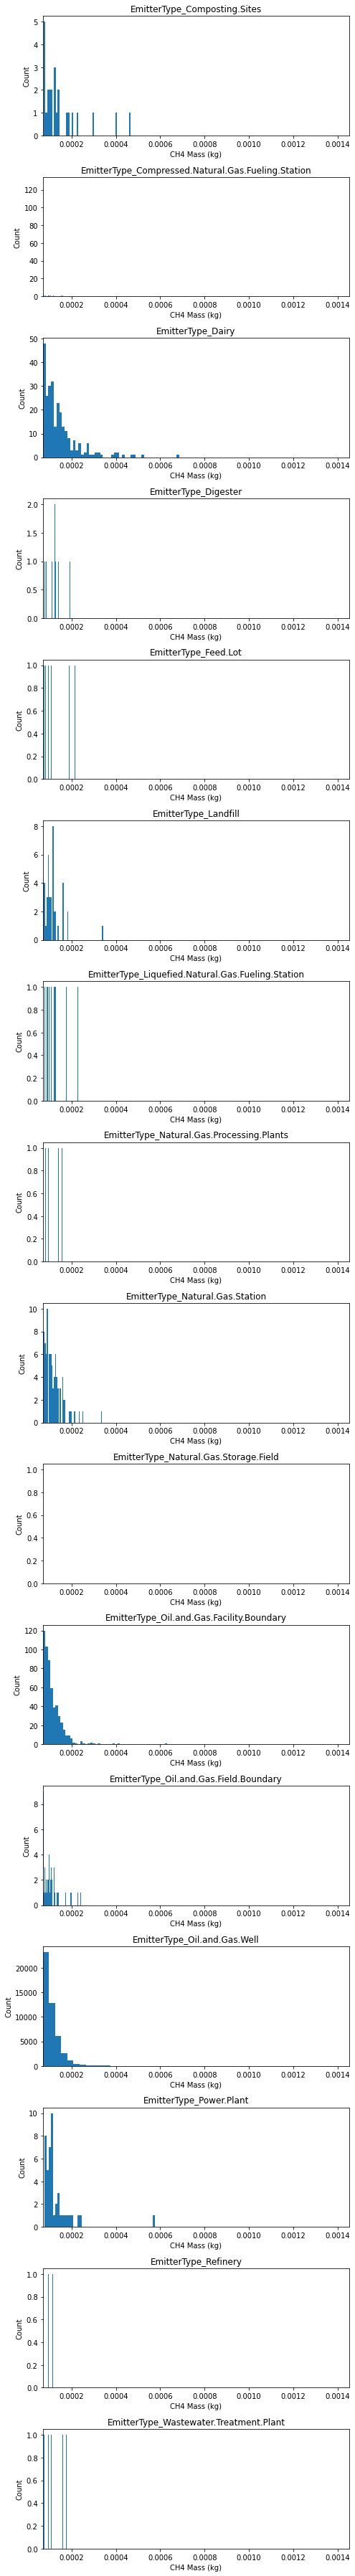

In [40]:
#Plot histogram of emissions level by each emitter type. 
fig, ax = plt.subplots(nrows = len(col_emitter_type), figsize = (7, 50))

for j, col in enumerate(col_emitter_type):
    data = gdf[['CH4_Mass_kg',col]]
    data = data.loc[data[col]==1]
    ax[j].hist(data['CH4_Mass_kg'], bins = 50)
    ax[j].set_xlim(gdf['CH4_Mass_kg'].min(),gdf['CH4_Mass_kg'].max())
    ax[j].set_title(str(col))
    ax[j].set_xlabel('CH4 Mass (kg)')
    ax[j].set_ylabel('Count')
plt.tight_layout()

#### Step 1: Train/Test Split

We'll first split our data into training (80%) and testing data (20%). 
The testing data will be used to evaluate how each our models perform.

We'll drop the columns that aren't features, as well as our dummy variables whose values are all 0. We'll also drop one of the dummy columns from each of the sets of categorical variables. We'll drop `LULC_Shrub.Scrub` and `EmitterType_Wastewater.Treatment.Plant`

In [125]:
#We'll need to create a dataframe of our X variables (features), and our y variable
features = np.setdiff1d(list(gdf.columns),
                        ['Vista_ID', 'AVIRIS_CH4_median_date','AVIRIS_CH4_pxcount', 
                         'CH4_Mass_kg','LULC_majority_class','NearestNeighbor',
                         'AVIRIS_CH4_median_ppmm','NN_Type','aviris_month', 'aviris_year','geometry', 
                        'LULC_Shrub.Scrub', 'EmitterType_Wastewater.Treatment.Plant'] + vars_0 )

X = gdf[features]
Y = gdf['CH4_Mass_kg']

In [126]:
#Create train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 15)

Standardization is an important step in using Ridge and Lasso models to ensure that all features are put on the same scale, since these models penalize large coefficients. We'll also create a train/test split for our standardized features, with the same `random_state` to ensure we have the same split as above. 

In [127]:
#Standardize features
scalar = StandardScaler()
scalar.fit(X)
X_std = scalar.transform(X)

In [128]:
#Create train/test split with standardized features
X_std_train, X_std_test, y_std_train, y_std_test = train_test_split(X_std, Y, test_size = 0.2, random_state = 15)



We will use `X_train` and `y_train` to fit each of our models in the sections below, and `X_test` and `y_test` to compare between models once we have fit the parameters and hyperparameters of each model. 

#### Model 1: Ordinary Least Squares Regression
To begin, we'll use Ordinary Least Squares Linear regression.

We'll start by using `statsmodels` to fit the model on our training data, as this package provides more detailed statistical information about linear regression models. This will allow us to examine statistics such as R-squared and the P-value for each of our coefficients. 

We'll then run the model in `scikit learn` on both our testing and training data. 

In [129]:
#For statsmodels, we need to include a column of one's to X so that it can fit an intercept. We'll add this column to 
# our training data to run the model. 
X_stats = sm.add_constant(X_train)

#Fit OLS regression
sm_model = sm.OLS(y_train, X_stats)
results = sm_model.fit()
results_summary = results.summary()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CH4_Mass_kg   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     30.50
Date:                Mon, 14 Dec 2020   Prob (F-statistic):          4.67e-275
Time:                        13:28:59   Log-Likelihood:             3.3266e+05
No. Observations:               38708   AIC:                        -6.652e+05
Df Residuals:                   38658   BIC:                        -6.648e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
EmitterType_Composting.Sites                        1.433e-05   2.45e-05      0.585      0.559   -3.37e-05    6.23e-05
EmitterType_Compressed.Natural.Gas.Fueling.Station -1.438e-05   2.29e-05     -0.628      0.530   -5.93e-05    3.05e-05
EmitterType_Dairy                                   2.031e-05   2.29e-05      0.887      0.375   -2.45e-05    6.52e-05
EmitterType_Digester                                9.749e-06   2.82e-05      0.346      0.730   -4.56e-05     6.5e-05
EmitterType_Feed.Lot                                1.381e-05   2.83e-05      0.489      0.625   -4.16e-05    6.92e-05
EmitterType_Landfill                               -9.774e-06   2.37e-05     -0.413      0.680   -5.62e-05    3.66e-05
EmitterType_Liquefied.Natural.Gas.Fueling.Station  -1.073e-06    2.9e-05     -0.037      0.970   -5.79e-05    5.57e-05
EmitterType_Natural.Gas.Processing.Plants           4.253e-06   3.17e-05      0.134      0.893    -5.8e-05    6.65e-05
EmitterType_Natural.Gas.Station                     -1.05e-05    2.3e-05     -0.456      0.649   -5.57e-05    3.47e-05
EmitterType_Natural.Gas.Storage.Field              -4.772e-05   3.89e-05     -1.228      0.219      -0.000    2.85e-05
EmitterType_Oil.and.Gas.Facility.Boundary          -4.932e-06   2.25e-05     -0.219      0.827   -4.91e-05    3.92e-05
EmitterType_Oil.and.Gas.Field.Boundary             -1.563e-05   2.38e-05     -0.658      0.511   -6.22e-05    3.09e-05
EmitterType_Oil.and.Gas.Well                       -8.973e-06   2.24e-05     -0.400      0.689   -5.29e-05     3.5e-05
EmitterType_Power.Plant                             4.891e-06   2.36e-05      0.208      0.836   -4.13e-05    5.11e-05
EmitterType_Refinery                               -1.378e-05   2.75e-05     -0.501      0.616   -6.77e-05    4.01e-05
LULC_Cultivated.Crops                               1.502e-05   5.35e-06      2.805      0.005    4.52e-06    2.55e-05
LULC_Dev..Low.Int                                  -2.004e-05    4.5e-05     -0.445      0.656      -0.000    6.82e-05
LULC_Dev..Med.Int                                   7.639e-07   4.47e-06      0.171      0.864      -8e-06    9.53e-06
LULC_Grassland                                      1.606e-05    5.3e-06      3.033      0.002    5.68e-06    2.64e-05
LULC_Mixed.Forest                                      0.0002   4.45e-05      4.013      0.000    9.14e-05       0.000
LULC_Open.Water                                     8.784e-07   4.64e-06      0.189      0.850   -8.22e-06    9.98e-06
LULC_barren_land_perc                                 -0.0012      0.000     -4.786      0.000      -0.002      -0.001
LULC_cultivated_crops_perc                            -0.0008      0.000     -3.583      0.000      -0.001  

Overall, our model had a $R^2$ value of 0.037, showing that our model doesn't seem to explain a large proportion of the variation in our response variable. However, AIC (a metric used to assess the quality of our model with a small value being better) could be improved by removing extraneous features via a model selection.

Looking at the t-statistic, where larger values are more significant, in conjunction with p values (should be at around 0), variables such as `OZONE`, `PM2.5`, `PM10`, `tropomi_o3_mean`, `tropomi_so2_mean`  `NN_Distance_m`, some of our LULC percent features, and `ng_pipelength_10000`/`50000`/`5000` seem to introduce the least error to the model.

Based off of these results we're skeptical about the significance of the following variables, since they include 0 within their 95% confidence interval: most of the `EmitterType` features,`LULC_Dev..*.Int`, `LULC_Open.Water`,  `ng_pipelength_1000`, `ng_pipelength_2`, and `tropomi_no2_mean`.

Let's compare these results with `scikit learn` to double check out work.

In [130]:
sk_model = linear_model.LinearRegression()
sk_fit = sk_model.fit(X_train,y_train)

print("Intercept:", sk_fit.intercept_)
# Coefficients
print("Coefficients:", sk_fit.coef_)

Intercept: 0.0010943481113179106
Coefficients: [ 1.43262489e-05 -1.43833748e-05  2.03119407e-05  9.74930076e-06
  1.38062426e-05 -9.77375924e-06 -1.07347175e-06  4.25326344e-06
 -1.04959533e-05 -4.77182843e-05 -4.93154595e-06 -1.56347331e-05
 -8.97282318e-06  4.89057841e-06 -1.37811480e-05  1.50162095e-05
 -2.00421416e-05  7.63930282e-07  1.60628573e-05  1.78555774e-04
  8.78391101e-07 -1.27273312e-03 -9.07707311e-04  1.20872618e-02
 -8.63200940e-04 -7.92802601e-04 -9.24405657e-04 -9.57148901e-04
 -1.01919866e-03 -9.35665253e-04 -9.15120023e-04 -9.17071323e-04
 -8.95585574e-04 -1.46619931e-03 -8.61121815e-04  1.75924000e-15
  6.40698632e-04  7.67703999e-09  9.70805910e-08  4.44246770e-07
 -2.06863392e-07  3.36508137e-07  6.16568784e-12  2.29864250e-10
  2.14449475e-10 -3.73640909e-10 -2.67335532e-11 -1.43162206e-01
 -1.84662916e-05 -1.05765006e-04  1.07726349e-07]


The coefficients seem to match up. 

Now, we'll fit the model in `scikit learn`, and evaluate how the model performs on the testing data. We'll create a function that fits a linear regression model and returns the training and test MSE. 

In [131]:
#Create a function  that fits a linear regression model and returns the training and test MSE. 
def OLS(X_train, y_train, X_test, y_test):
    """ Fits an Ordinary Least Squares Linear regression on the training set of X and y,
    and finds the MSE of the training and test set. 
    Arguments:
        X_train: An ndarray containing the set of features used to train the model. 
        y_train: A list/array containing containing the set of response variable observations used to train the model.
        X_test: An ndarray containing the set of features used to test the model.
        y_test: A list/array containing the set of response variable observations used to test the model. 
    Returns:
        train_mse: the MSE for the training data
        test_mse: The MSE for the test data
        """
    #Fit model
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    
    #Get training MSE
    train_mse = mean_squared_error(y_train, lm.predict(X_train))
    
    #Get test MSE
    test_mse = mean_squared_error(y_test, lm.predict(X_test))
    
    return train_mse, test_mse

We can utilize our function to fit the model using Ordinary Least Squares Linear regression. 

In [132]:
ols_train_mse, ols_test_mse = OLS(X_train, y_train, X_test, y_test)
print("Training MSE: ", ols_train_mse)
print("Test MSE: ", ols_test_mse)

Training MSE:  2.007657950320034e-09
Test MSE:  1.900341613335858e-09


It seems that our MSE is very small. However, this is also likely a factor of the scale of our response variable. Since our AIC is so large in this version of the OLS model, we'll vary the number of features we use to see what will improve the quality of our model.

We'll figure out what variables we may want to add first by sorting it on the t and p statistics.

In [133]:
# Take our results summary table and make it a dataframe
results_as_html = results_summary.tables[1].as_html()
results_summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0].reset_index()

# Get absolute t value
results_summary_df['t_abs'] = np.absolute(results_summary_df['t'])

# Sort by large t and small p
results_summary_df = results_summary_df.sort_values(by=['t_abs', 'P>|t|'], ascending=[False,True])
results_summary_df

,index,coef,std err,t,P>|t|,[0.025,0.975],t_abs
40,PM10,-2.069000e-07,1.720000e-08,-12.010,0.000,-2.410000e-07,-1.730000e-07,12.010
45,ng_pipelength_5000,-3.736000e-10,3.550000e-11,-10.511,0.000,-4.430000e-10,-3.040000e-10,10.511
43,ng_pipelength_10000,2.299000e-10,2.280000e-11,10.098,0.000,1.850000e-10,2.740000e-10,10.098
49,tropomi_so2_mean,-1.000000e-04,1.330000e-05,-7.970,0.000,-0.000000e+00,-7.980000e-05,7.970
46,ng_pipelength_50000,-2.673000e-11,4.010000e-12,-6.666,0.000,-3.460000e-11,-1.890000e-11,6.666
33,LULC_pasture_hay_perc,-1.400000e-03,0.000000e+00,-5.757,0.000,-2.000000e-03,-1.000000e-03,5.757
48,tropomi_o3_mean,-1.847000e-05,3.220000e-06,-5.742,0.000,-2.480000e-05,-1.220000e-05,5.742
47,tropomi_no2_mean,-1.432000e-01,2.600000e-02,-5.580,0.000,-1.930000e-01,-9.300000e-02,5.580
39,OZONE,4.442000e-07,8.970000e-08,4.953,0.000,2.680000e-07,6.200000e-07,4.953
21,LULC_barren_land_perc,-1.200000e-03,0.000000e+00,-4.786,0.000,-2.000000e-03,-1.000000e-03,4.786


In [134]:
#Sort by largest coefficient (absolute value)
results_summary_df['coef_abs'] = np.absolute(results_summary_df['coef'])
results_summary_df.sort_values(by=['coef_abs'], ascending=[False]).head()

,index,coef,std err,t,P>|t|,[0.025,0.975],t_abs,coef_abs
47,tropomi_no2_mean,-0.1432,0.026,-5.580,0.000,-0.193,-0.093,5.580,0.1432
23,LULC_deciduous_forest_perc,0.0122,0.004,3.457,0.001,0.005,0.019,3.457,0.0122
33,LULC_pasture_hay_perc,-0.0014,0.000,-5.757,0.000,-0.002,-0.001,5.757,0.0014
21,LULC_barren_land_perc,-0.0012,0.000,-4.786,0.000,-0.002,-0.001,4.786,0.0012
35,LULC_total_perc,0.0010,0.000,4.370,0.000,0.001,0.001,4.370,0.0010


Above, we can see that the most important variable is `PM10`, which makes sense intuitively, as PM10 can be a pollutant that spans from high emitters. However, the coefficient is negative, indicating a negative correlation, which is not what we would expect. `tropomi_no2_mean` also has a negative correlation.

In terms of coefficient size, `LULC_deciduous_forest_perc` and `tropomi_no2_mean` have the largest values.

`LULC_deciduous_forest_perc` has a positive correlation, which is again not what we would expect. `LULC_emergent_herbaceous_wetlands_perc` has a negative correlation with a very small coefficient; here, the negative correlation does make sense, since we'd be less likely to see a methane-emitting facility located in areas that are majority wetlands (although wetlands are methane emitters, they are not anthropogenic sources, and thus are not included in our dataset). 

In [135]:
# Sort variables in order we think they're important (important ones first)
vars_to_add = results_summary_df['index']

And then we'll compute AIC and the loglikelihood function.

In [136]:
def computeAIC(fit_model,k):
    llf = fit_model.llf # get likelihood
    AIC = 2*k - 2*llf # calculate AIC
    
    return AIC

In [137]:
AIC_results = []
llf_results = []

for i, var in enumerate(vars_to_add):
    X_subset = X_train[vars_to_add[:i]]
    X2 = sm.add_constant(X_subset)
    sm_model = sm.OLS(y_train, X2)
    results = sm_model.fit()
    
    llf_results.append(results.llf)
    AIC_results.append(computeAIC(results,i))

We can visualize our results:

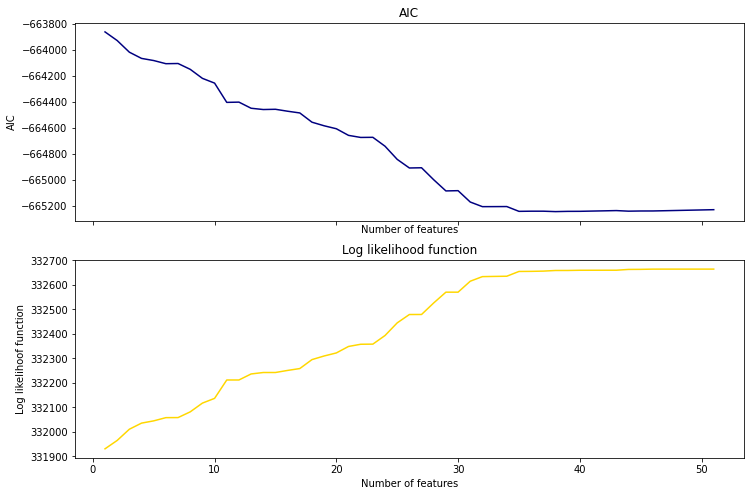

In [138]:
fig, (ax0,ax1) = plt.subplots(nrows=2, sharex=True, figsize = (12,8))

# AIC
ax0.plot(np.arange(1,len(vars_to_add)+1), AIC_results, color = 'navy')
ax0.set_xlabel('Number of features')
ax0.set_ylabel('AIC')
ax0.set_title('AIC')

# Log likelihood function
ax1.plot(np.arange(1,len(vars_to_add)+1), llf_results, color = 'gold')
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Log likelihoof function')
ax1.set_title('Log likelihood function')

plt.show()

In [139]:
print("Best model based on AIC: ", np.argmin(AIC_results))
print("Best model based on LLF: ", np.argmax(llf_results))

Best model based on AIC:  37
Best model based on LLF:  50


If we choose our model based on a low AIC we would have the following variables:

In [140]:
print("Features for model  (based on AIC): \n", vars_to_add.iloc[:np.argmin(AIC_results)])

Features for model  (based on AIC): 
 40                                                 PM10
45                                   ng_pipelength_5000
43                                  ng_pipelength_10000
49                                     tropomi_so2_mean
46                                  ng_pipelength_50000
33                                LULC_pasture_hay_perc
48                                      tropomi_o3_mean
47                                     tropomi_no2_mean
39                                                OZONE
21                                LULC_barren_land_perc
35                                      LULC_total_perc
19                                    LULC_Mixed.Forest
28               LULC_emergent_herbaceous_wetlands_perc
41                                                PM2.5
27                       LULC_developed_open_space_perc
29                           LULC_evergreen_forest_perc
30                       LULC_grassland_herbaceous_perc
26        

We can re-run our model based on that to get our best quality model.

In [141]:
X_train_OLS = X_train[list(np.array(vars_to_add.iloc[:np.argmin(AIC_results)]))]
X_train_OLS

,PM10,ng_pipelength_5000,ng_pipelength_10000,tropomi_so2_mean,ng_pipelength_50000,LULC_pasture_hay_perc,tropomi_o3_mean,tropomi_no2_mean,OZONE,LULC_barren_land_perc,...,LULC_Cultivated.Crops,LULC_woody_wetlands_perc,ng_pipelength_2,weighted_cow_density,NO2,EmitterType_Natural.Gas.Storage.Field,EmitterType_Dairy,EmitterType_Oil.and.Gas.Field.Boundary,EmitterType_Compressed.Natural.Gas.Fueling.Station,EmitterType_Composting.Sites
10229,44.252134,108152.657178,140722.274852,0.384585,601778.142930,0.000036,2.685531,0.000024,62.341167,0.008532,...,0,0.000000,70554.851525,12.588844,6.955166,0,0,0,0,0
5341,50.315139,38259.249429,87642.485819,0.354530,456859.018159,0.000498,2.506767,0.000029,53.920130,0.010290,...,0,0.000000,7316.916325,16.253027,5.152299,0,0,0,0,0
40655,61.950983,154828.596419,203813.182168,0.351939,923810.878832,0.007057,2.697107,0.000033,65.343013,0.004250,...,0,0.010155,95561.852291,16.253027,11.056380,0,0,0,0,0
14223,92.058187,116268.676765,181552.833317,0.357810,885904.676751,0.006393,2.695420,0.000033,66.150266,0.003153,...,0,0.007766,73803.610603,16.253027,9.893962,0,0,0,0,0
42425,51.798751,134636.730230,209358.007358,0.312749,646393.477722,0.012380,2.697720,0.000064,51.037877,0.003562,...,0,0.000177,62140.599891,0.459964,20.620934,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35483,59.145893,132635.977068,181880.312966,0.350027,950809.009868,0.006425,2.504059,0.000033,60.239961,0.003672,...,0,0.003356,81461.235300,16.253027,6.493642,0,0,0,0,0
39296,40.747207,85861.210929,117742.294870,0.324675,288722.021730,0.024859,2.697917,0.000033,52.088547,0.004987,...,0,0.003727,51754.882630,1.005362,10.099150,0,0,0,0,0
2693,106.750935,145165.276042,209865.542067,0.359105,966801.514306,0.006400,2.695575,0.000034,66.150266,0.003625,...,0,0.004399,102308.905460,16.253027,9.893962,0,0,0,0,0
8076,89.686209,149717.918774,203852.640228,0.354328,929427.654450,0.006436,2.697020,0.000034,66.150266,0.003923,...,0,0.008986,91919.195187,16.253027,11.056380,0,0,0,0,0


In [142]:
X_test_OLS = X_test[list(np.array(vars_to_add.iloc[:np.argmin(AIC_results)]))]

In [143]:
ols_train_mse_2, ols_test_mse_2 = OLS(X_train_OLS, y_train,
                                  X_test_OLS, y_test)
print("Training MSE: ", ols_train_mse_2)
print("Test MSE: ", ols_test_mse_2)

Training MSE:  2.0082391024769198e-09
Test MSE:  1.9011093780187535e-09


Compared with our prior train/test MSE from our model with all the features: 

In [144]:
#Calculate difference 
print('Training MSE Improvement:', ols_train_mse - ols_train_mse_2)
print('Test MSE Improvement:', ols_test_mse - ols_test_mse_2)

Training MSE Improvement: -5.811521568858204e-13
Test MSE Improvement: -7.677646828954105e-13


We can see that there actually wan't an improvement: our full OLS performed better than our AIC subset selection. 

#### Model 2: Ridge Regression
Since we have a large number of features in our model, we'll also want to try regularization methods; namely Ridge and Lasso Regression. These methods are computationally faster than subset selection, and can help reduce model variance associated with a large number of features.

We saw that in the OLS, our AIC was very large when we created the first version of our model including all of the features we had originally gathered. We can take advantage of Ridge here since it shrinks our coefficients toward zero, without ever fully eliminating them.

We'll begin by creating a function that fits the model, including tuning the hyperparameters, using K-fold cross validation. Considering the large size of our dataset, K-fold cross-validation will save a significant amount of computing time, as opposed to Leave One Out Cross Validation. In our case, we'll use 10 folds, following convention. 

In the case of Ridge and Lasso, the only hyperparameter we need to tune is our shrinkage penalty, which we'll denote here as `alpha`. 

To see how different alpha values perform, we'll also define a model to calculate the MSE for a range of alpha values during the KFold cross validation process on our training data. This way, we can visualize the MSEs for different alpha values to ensure we are choosing the optimal value. 

In [145]:
#First, we can define a model to get the MSE on our training data for a range of alpha values 
def model_mse_cv(Model, X_train, y_train, alphas, k):
    """
    Calculates the MSE resulting from k-fold CV using Lasso or Ridge regression performed on X_train and 
    y_train for a range of values of alpha.
    Inputs: 
        Model (sklearn model): the type of sklearn model with which to fit the data: Ridge, or Lasso
        X_train: the set of features used to fit the model
        y_train: the set of response variable observations
        alphas: a list of alpha values
        k: number of folds in k-fold cross-validation
    Returns:
        mses: a list containing the mean squared cross-validation error corresponding to each value of alpha
    """
    #Initialize MSE array
    mses = np.full((k, len(alphas)), np.nan) 
    
    #Kfold split
    kf = KFold(n_splits = k, shuffle = True, random_state = 15) 
    
    fold = 0
    for train_i, val_i in kf.split(X_train):
        
        # get training and validation values
        X_f_train = X_train[train_i]
        X_f_val = X_train[val_i]
        y_f_train = np.array(y_train)[train_i]
        y_f_val = np.array(y_train)[val_i]
        
        for i in range(len(alphas)): 
            model = Model(alpha = alphas[i]) 

            model.fit(X_f_train, y_f_train) 
            
            y_pred = model.predict(X_f_val) 
            
            # save MSE for this fold and alpha value
            mses[fold, i] = mean_squared_error(y_pred, y_f_val)
        
        fold += 1
    
    # get average MSE for each alpha value across folds
    average_mses = np.zeros(len(alphas)) 
    for i in range(len(alphas)):
        average_mses[i] = np.mean(mses[:, i])
    
    return average_mses

We'll test this function on a range of alphas, and plot the MSE for each alpha value. 

In [146]:
#Define list of alpha values 
ridge_alphas = np.linspace(0.01, 200, 100)

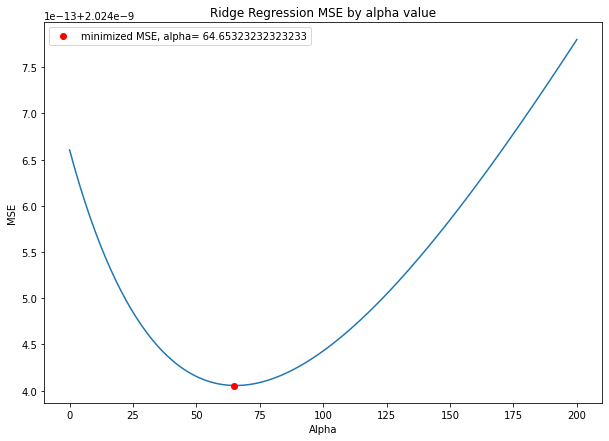

In [147]:
plt.figure(figsize = (10, 7))

#Get MSEs for training data using Ridge Regression
mse_ridge = model_mse_cv(Ridge, X_std_train, y_std_train, ridge_alphas, 10)
plt.plot(ridge_alphas, mse_ridge)
plt.plot(ridge_alphas[np.argmin(mse_ridge)], min(mse_ridge), 'ro', label = 'minimized MSE, alpha= ' + 
         str(ridge_alphas[np.argmin(mse_ridge)]))
plt.title("Ridge Regression MSE by alpha value")
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.legend()

From this graph, we can see that we reach our minimum alpha value at approximately 65. The graph has a clear minimum, with the MSE increasing substantially on either side of this minimum. 

Now, we can fit the model and see how it performs on our test data. 

In [148]:
#Define model for Ridge and Lasso Cross Validation
def fit_model_cv(Model, X_train, y_train, X_test, y_test, kf, alphas):
    """Fits a Ridge or Lasso model with K-fold cross-validation on the training set of X and y, 
    and finds the MSE of the training and test set. 
    Arguments:
        Model: The type of Model to use, RidgeCV or LassoCV.
        X_train: An ndarray containing the set of features used to train the model.
        y_train: A list/array containing the set of response variable observations used to train the model. 
        X_test: An ndarray containing the set of features used to test the model. 
        y_test: A list/array containing the set of response variable observations used to test the model. 
        kf: a KFold cross-validation selector object.
            [Note: This should have n_splits, shuffle, and random_state specified]. 
        alphas: a list of alpha values to test during the cross-validation process
    Returns:
        train_mse: the MSE for the training data
        test_mse: the MSE for the test data
        opt_alpha: the optimal alpha value"""
    
    #Fit model
    modelcv = Model(cv = kf, alphas = alphas)
    modelcv.fit(X_train, y_train)
    
    #Get optimal alpha value
    opt_alpha = modelcv.alpha_
    
    #Get training MSE
    train_mse = mean_squared_error(y_train, modelcv.predict(X_train))
    
    #Get test MSE
    test_mse = mean_squared_error(y_test, modelcv.predict(X_test))
    
    #Get coefficients
    coefficients = modelcv.coef_

    return train_mse, test_mse, opt_alpha, coefficients   

We'll define a KFold cross validation selector object, and use the list of alphas we defined above. 

In [149]:
#Define K-Fold cross-validation object
kf = KFold(n_splits = 10, shuffle = True, random_state = 15)

Now, we can utilize our function to find the optimal model using Ridge Regression. 

In [150]:
#Fit model
r_train_mse, r_test_mse, r_alpha, r_coef = fit_model_cv(RidgeCV, 
                                                X_std_train, 
                                                y_std_train, 
                                                X_std_test, 
                                                y_std_test, 
                                                kf, 
                                                ridge_alphas)
print("Training MSE: ", r_train_mse)
print("Test MSE: ", r_test_mse)
print("Optimal Alpha Value: ", r_alpha)

Training MSE:  2.0078043240238605e-09
Test MSE:  1.901163098958823e-09
Optimal Alpha Value:  62.633131313131315


We can compare how the test MSE for our ridge regression performs against both versions of our OLS model. 

In [151]:
#Compare test MSE between models
compare_mses = np.array([ols_test_mse, ols_test_mse_2, r_test_mse])
compare_models = np.array(['OLS','OLS selected','Ridge'])
print("Lowest Test MSE:", np.min(compare_mses))
print(compare_models[np.argmin(compare_mses)])

Lowest Test MSE: 1.900341613335858e-09
OLS


Between the Ridge, OLS with subset selection using AIC, and OLS with all of our features, the OLS with all of our features performed the best. 

We are also interested in seeing how our coefficients change with Ridge regression. 

In [152]:
#Create dataframe with coefficients
coef = pd.DataFrame({'Feature': X.columns, 'Index': np.arange(X.shape[1]), 
                    'Ridge': r_coef})

Text(0.5, 1.0, 'Ridge Coefficients')

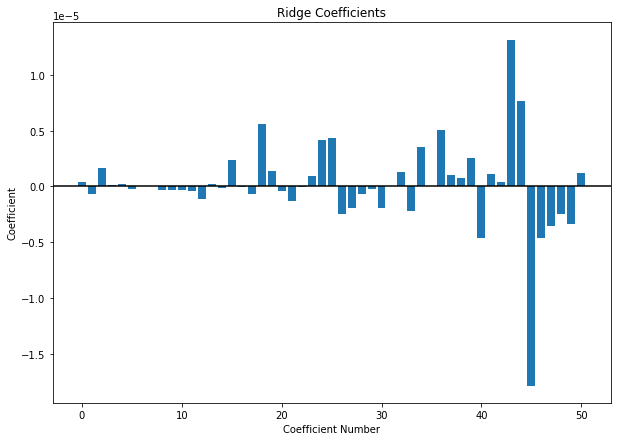

In [153]:
#Plot Coefficients
plt.figure(figsize = (10,7))
plt.bar(x = coef['Index'], height = coef['Ridge'])
plt.axhline(0, color = 'black')
plt.xlabel('Coefficient Number') 
plt.ylabel('Coefficient')
plt.title('Ridge Coefficients')

Let's look at which coefficients were the most significant for our Ridge regression. 

In [154]:
#Sort coefficients from largest in absolute value to smallest
coef.iloc[(-coef['Ridge'].abs()).argsort()]

,Feature,Index,Ridge
45,ng_pipelength_5000,45,-1.785150e-05
43,ng_pipelength_10000,43,1.316603e-05
44,ng_pipelength_2,44,7.675009e-06
18,LULC_Grassland,18,5.588295e-06
36,LULC_woody_wetlands_perc,36,5.030137e-06
40,PM10,40,-4.597893e-06
46,ng_pipelength_50000,46,-4.594258e-06
25,LULC_developed_low_int_perc,25,4.367891e-06
24,LULC_developed_high_int_perc,24,4.166004e-06
47,tropomi_no2_mean,47,-3.585839e-06


This time, `ng_pipeline_5000` was the most significant feature, followed by `ng_pipelength_10000`, which were both significant in our OLS model as well. `ng_pipelength_2` and `LULC_Grassland` were also significant. 

Since the majority of our emitter points are oil and gas wells, it makes sense that our natural gas pipeline features are significant in this model. 

#### Model 3: Lasso Regression
Lasso, similar to Ridge, will shrink our coefficients; however, Lasso has the benefit of also performing subset selection, since some coefficients can be shrunk to zero. We'll try this model next, and see if we can achieve a better performance. 

Lasso has an advantage over Ridge when a small number of predictors have large coefficients. So far, this doesn't seem to be the case with our model; however, we'll still want to try this model to compare performance. 

For our Lasso model, we'll use the same K-Fold cross validation. However, we'll define a new set of alpha values, since optimal Lasso alpha values tend to have a smaller range than Ridge alpha values. 

In [155]:
#Define lasso alpha values
lasso_alphas = np.linspace(1e-5, 10, 100)

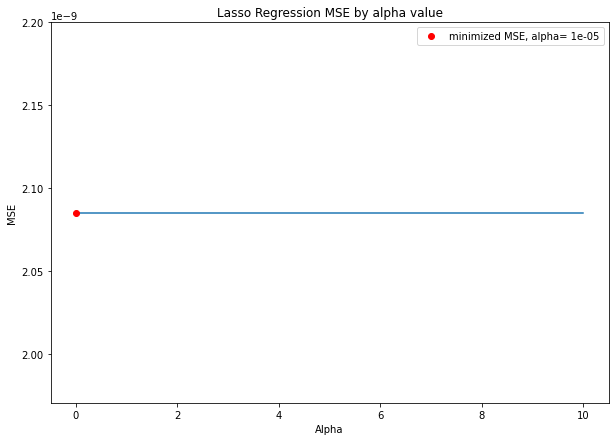

In [156]:
plt.figure(figsize = (10, 7))

#Get MSEs for training data using Ridge Regression
mse_lasso = model_mse_cv(Lasso, X_std_train, y_std_train, lasso_alphas, 10)
plt.plot(lasso_alphas, mse_lasso)
plt.plot(lasso_alphas[np.argmin(mse_lasso)], min(mse_lasso), 'ro', label = 'minimized MSE, alpha= ' + 
         str(lasso_alphas[np.argmin(mse_lasso)]))
plt.title("Lasso Regression MSE by alpha value")
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.legend()

The plot above gives us strange results. It seems that the MSE is the same regardless of the alpha value. This may be because Lasso shrinks all our coefficients to zero. Let's see if this is the case. 

In [157]:
#Fit model
l_train_mse, l_test_mse, l_alpha, l_coef = fit_model_cv(LassoCV, 
                                                X_std_train, 
                                                y_std_train, 
                                                X_std_test, 
                                                y_std_test, 
                                                kf, 
                                                lasso_alphas)
print("Training MSE: ", l_train_mse)
print("Test MSE: ", l_test_mse)
print("Optimal Alpha Value: ", l_alpha)

Training MSE:  2.085267826741991e-09
Test MSE:  1.946743222028358e-09
Optimal Alpha Value:  10.0


In [158]:
l_coef

array([ 0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0., -0.,
        0., -0.,  0.,  0., -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,
        0., -0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0.,  0.])

The results show us that Lasso did indeed shrink all our coefficients to zero. We'll try an even smaller starting range of alpha values to see if this changes anything. Unfortunately, we can't start too small, or `scikitlearn` will give an error since the alpha values need to be greater than zero. We'll try one order of magnitude smaller. 

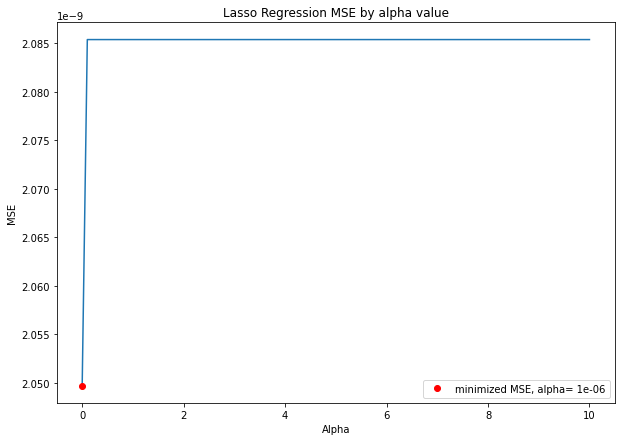

In [159]:
#Define lasso alpha values
lasso_alphas = np.linspace(1e-6, 10, 100)

plt.figure(figsize = (10, 7))

#Get MSEs for training data using Ridge Regression
mse_lasso = model_mse_cv(Lasso, X_std_train, y_std_train, lasso_alphas, 10)
plt.plot(lasso_alphas, mse_lasso)
plt.plot(lasso_alphas[np.argmin(mse_lasso)], min(mse_lasso), 'ro', label = 'minimized MSE, alpha= ' + 
         str(lasso_alphas[np.argmin(mse_lasso)]))
plt.title("Lasso Regression MSE by alpha value")
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.legend()

We managed to get a minimum MSE value with a very small Lasso value. Now we can run the model again to see the results. 

In [160]:
#Fit model
l_train_mse, l_test_mse, l_alpha, l_coef = fit_model_cv(LassoCV, 
                                                X_std_train, 
                                                y_std_train, 
                                                X_std_test, 
                                                y_std_test, 
                                                kf, 
                                                lasso_alphas)
print("Training MSE: ", l_train_mse)
print("Test MSE: ", l_test_mse)
print("Optimal Alpha Value: ", l_alpha)

Training MSE:  2.045495161588082e-09
Test MSE:  1.9174961606598774e-09
Optimal Alpha Value:  1e-06


Let's take a look at the coeffiicients, and how they compare to Ridge.

In [161]:
coef['Lasso'] = l_coef

Text(0.5, 1.0, 'Lasso & Ridge Coefficients')

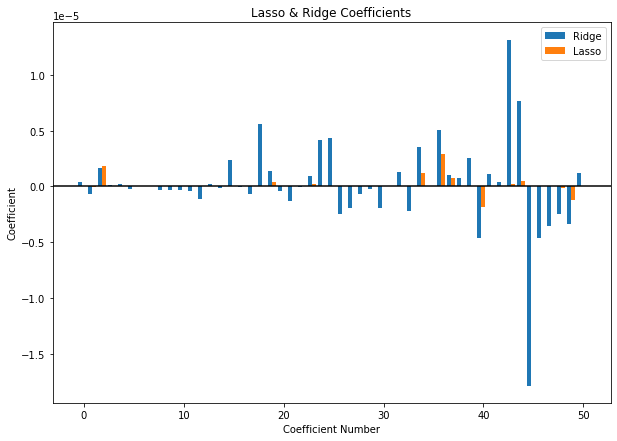

In [162]:
#Plot Coefficients
ind = np.arange(coef.shape[0])
width = 0.4
pos = np.array([ind-width, ind])

plt.figure(figsize = (10,7))

for i in np.arange(2):
    plt.bar(x = pos[i], height = coef.iloc[:, i + 2], width = width, label = coef.columns[i+2])
plt.legend()
plt.axhline(0, color = 'black')
plt.xlabel('Coefficient Number') 
plt.ylabel('Coefficient')
plt.title('Lasso & Ridge Coefficients')

Our Lasso model substantially reduced our number of features. Let's take a look at which feature coefficients are greater than 0. 

In [163]:
#subset by Lasso coefficients not equal to 0
lasso = coef[coef['Lasso'] != 0]

#Sort coefficients from largest in absolute value to smallest
lasso.iloc[(-lasso['Lasso'].abs()).argsort()]

,Feature,Index,Ridge,Lasso
36,LULC_woody_wetlands_perc,36,5.030137e-06,2.874571e-06
2,EmitterType_Dairy,2,1.655051e-06,1.842418e-06
40,PM10,40,-4.597893e-06,-1.819441e-06
34,LULC_shrub_scrub_perc,34,3.514198e-06,1.231833e-06
49,tropomi_so2_mean,49,-3.413048e-06,-1.211177e-06
37,NN_Distance_m,37,9.852038e-07,7.340166e-07
44,ng_pipelength_2,44,7.675009e-06,5.127089e-07
19,LULC_Mixed.Forest,19,1.357012e-06,3.943674e-07
43,ng_pipelength_10000,43,1.316603e-05,2.234318e-07
23,LULC_deciduous_forest_perc,23,9.347386e-07,2.217535e-07


Interestingly, for our Lasso model, the most significant feature was not the same as those that were significant in our Ridge and OLS models. Here, we have `LULC_woody_wetlands_perc`, `EmitterType_Dairy`, `PM10` as our three most significant features. 

#### Model Comparison: OLS, Ridge, and Lasso

Below, we'll compare the test MSE for all our models. 

In [164]:
#Print OLS
print("OLS Test MSE: ", ols_test_mse)
print("OLS Test MSE feature selection using AIC: ", ols_test_mse_2)

#Print Ridge Values
print("Ridge Test MSE: ", r_test_mse)

#Print Lasso Values
print("Lasso Test MSE: ", l_test_mse)

OLS Test MSE:  1.900341613335858e-09
OLS Test MSE feature selection using AIC:  1.9011093780187535e-09
Ridge Test MSE:  1.901163098958823e-09
Lasso Test MSE:  1.9174961606598774e-09


In [165]:
#Find the index of the lowest MSE
all_mses = np.array([ols_test_mse, ols_test_mse_2, r_test_mse, l_test_mse])
all_models = np.array(['OLS','OLS selected','Ridge','Lasso'])
print("Lowest Test MSE:", np.min(all_mses))
print(all_models[np.argmin(all_mses)])

Lowest Test MSE: 1.900341613335858e-09
OLS


Our full **OLS model performs the best**. 

The variation in most significant features throughout all of our models show us that across all three of our models, there wasn't a clear set of features that are consistently good predictors of methane emissions from the emitters included in our dataset. Our `ng_pipelength_5000` and `ng_pipelength10000` tended to be better predictors, as they had a coefficient that was significant in both our OLS and Ridge models. `PM10` and `tropomi_so2_mean` and `tropomi_o3_mean` also tended to be significant across our models.

With our predictions we can map our results from each model. If we had more time, we could have predicted methane at locations that aren't in the Vista dataset. But for this exercise let's just use the testing subset and see how those predictions differ from our response variable.

Let's first set up a function that gives us the predicted value for our model.

In [166]:
def fit_model_predict(Model, X_train, X_test, y_train, y_test, alpha = 1):
    """
    This function fits a model of type Model to the data in the training set of X and y,
    and returns the predicted values
    Inputs: 
        Model (sklearn model): the type of sklearn model with which to fit the data - LinearRegression, Ridge, or Lasso
        X_train: the set of features used to train the model
        y_train: the set of response variable observations used to train the model
        X_test: the set of features used to test the model
        y_test: the set of response variable observations used to test the model
        alpha: the penalty parameter, to be used with Ridge and Lasso models only
    """    
    
    if Model == LinearRegression:
        model = Model()
    else:
        model = Model(alpha = alpha)
        
    model.fit(X_train, y_train)
    
    return model.predict(X_test)

And now let's use the above function to find the predicted values off of the test portion of our data

In [167]:
# Combine tested results from our three models and actual
compare_gdf = gdf.iloc[y_test.index][['Vista_ID', 'AVIRIS_CH4_median_date',
                                      'AVIRIS_CH4_pxcount', 'CH4_Mass_kg',
                                      'LULC_majority_class','geometry']].reset_index(drop=True)

# Predict OLS
compare_gdf['ols'] = fit_model_predict(LinearRegression, X_train, X_test, y_train, y_test)

# Predict Lasso
compare_gdf['ridge'] = fit_model_predict(Ridge, X_std_train, X_std_test, y_std_train, y_std_test, alpha = r_alpha)

# Predict lasso
compare_gdf['lasso'] = fit_model_predict(Lasso, X_std_train, X_std_test, y_std_train, y_std_test,alpha = l_alpha)

compare_gdf.head()

,Vista_ID,AVIRIS_CH4_median_date,AVIRIS_CH4_pxcount,CH4_Mass_kg,LULC_majority_class,geometry,ols,ridge,lasso
0,OGW104152,2017-09-06,484.551724,0.000094,Grassland,"MULTIPOLYGON (((93473.881 -287304.442, 93473.0...",0.000117,0.000117,0.000113
1,OGW076542,2017-10-10,1527.400000,0.000113,Grassland,"MULTIPOLYGON (((54687.648 -304351.272, 54686.8...",0.000123,0.000122,0.000113
2,OGW105331,2017-09-05,743.333333,0.000082,Grassland,"MULTIPOLYGON (((94342.214 -285248.417, 94341.3...",0.000112,0.000113,0.000114
3,OGW179513,2017-10-03,1190.666667,0.000108,Grassland,"MULTIPOLYGON (((100454.618 -280232.376, 100453...",0.000120,0.000121,0.000119
4,OGW135655,2017-09-02,1730.750000,0.000119,Grassland,"MULTIPOLYGON (((-34848.114 -198266.118, -34848...",0.000102,0.000102,0.000102


And now let's plot!

In [168]:
# find vmin and vmax for plotting colorbar extent
vmin = compare_gdf[['CH4_Mass_kg','ols','ridge','lasso']].min().min()
vmax = compare_gdf[['CH4_Mass_kg','ols','ridge','lasso']].max().max()
print(vmin,vmax)

5.26722443262767e-05 0.000933680408006129


In [169]:
# bring in california outline
ca_boundary = gpd.read_file('zip://data/ca-state-boundary.zip')
ca_boundary.to_crs(compare_gdf.crs, inplace=True)

/Users/michellesims/opt/anaconda3/envs/pp275/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [172]:
def comparison_maps(vmin, vmax, xmin=None, xmax=None, ymin=None, ymax=None):
    '''
    Plots results from OLS, Ridge, Lasso with actual values
    If x lim and y lim values are specified they will be used 
    '''
    
    fig, ax = plt.subplots(2,2, figsize=(10,10))

    plt_titles = ['CH$_4$ measurement','OLS','Ridge','Lasso']

    ax_ravel = ax.ravel().tolist()

    for i, col in enumerate(['CH4_Mass_kg','ols','ridge','lasso']):

        # add california outline
        ca_boundary.plot(color='lightgrey', ax=ax_ravel[i])

        # Plot CH4 values
        plt_ch4 = compare_gdf[[col, 'geometry']].plot(column=col, ax=ax_ravel[i], vmin=vmin, vmax=vmax)

        # Remove tick marks and frame
        ax_ravel[i].set_frame_on(False)
        plt.setp(ax_ravel[i].get_xticklabels(), visible=False)
        plt.setp(ax_ravel[i].get_yticklabels(), visible=False)
        ax_ravel[i].set_xticks([])
        ax_ravel[i].set_yticks([])

        ax_ravel[i].set_title(plt_titles[i])
        
        if xmin!=None and xmax!=None and ymin!=None and ymax!=None:
            ax_ravel[i].set_xlim(xmin, xmax)
            ax_ravel[i].set_ylim(ymin,ymax)

    fig.tight_layout()
    # Note: since colorbar is manu`enter code here`ally added, tight_layout must be called before
    # rendering colorbar
    plt.colorbar(plt_ch4.collections[-1], ax=ax.ravel().tolist(), label='Ch$_4$ (kg)')
    plt.show()

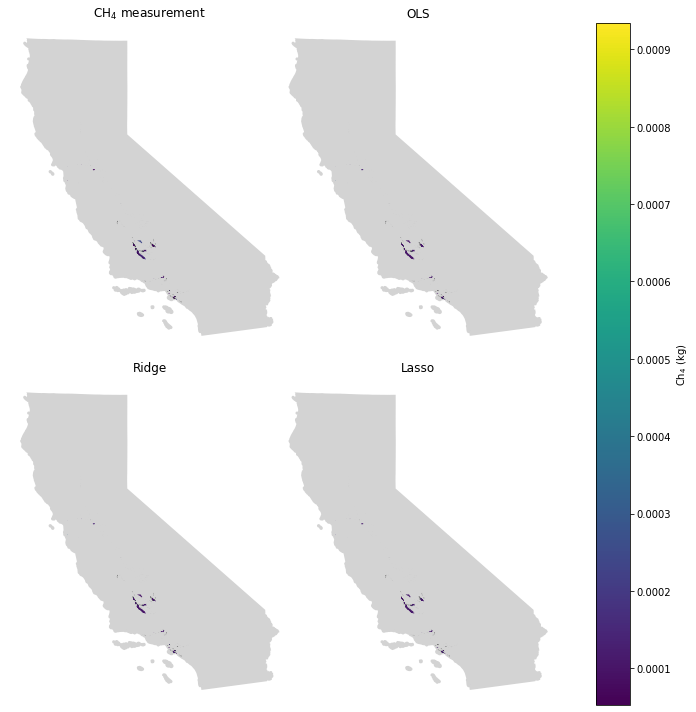

In [173]:
comparison_maps(vmin=vmin, vmax=vmax)

Since it's pretty hard to tell from this zoomed our version, let's zoom into where we see a cluster of predictions.

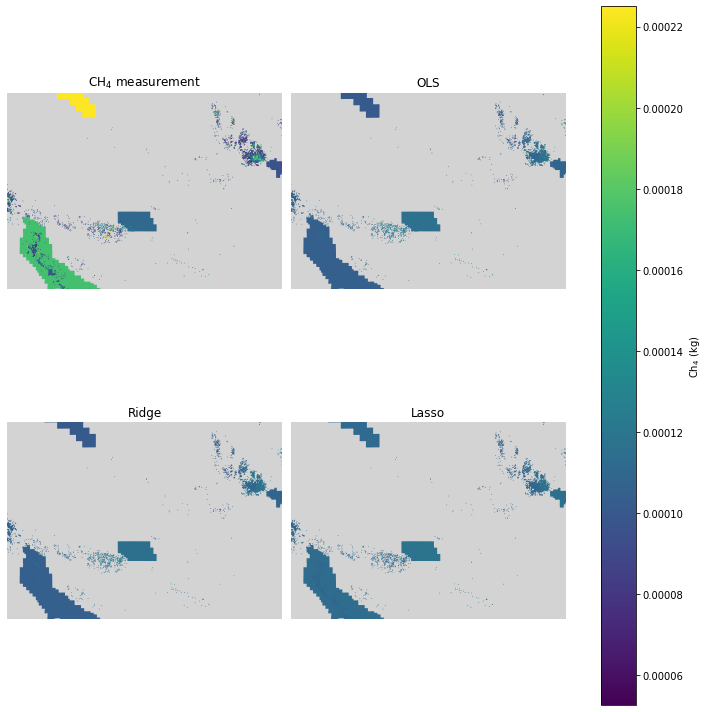

In [174]:
comparison_maps(vmin=vmin, vmax=0.000225, xmin=30000,xmax=100000,ymin=-320000,ymax=-270000)

From these maps, we can see that our model isn't quite picking up the nuances and variation in methane emissions across sources. As we saw from the very small differences in our MSEs across models, although our OLS model performs the best, we don't see a clear visual distinction between the predictions made between these models. 

To improve our model in the future, we'll want to include additional features that can enhance our model performance. Since such a high percentage of our emitter types are oil and gas wells, we would likely want to identify features related to characteristics of these facilities that might be linked to the quantity of methane emissions. In the future, we may want to see if we could acquire enough data from Tropomi CH4 measurements to include it as a feature in our model. 

### Question 3: Estimating the minimum necessary size of a sensor network

#### Problem statement

*How many sensors would it take to reliably predict CH$_4$ at the facility level across the state?*

In Question 2, we saw that our model was able to predict CH$_4$ at the emitting-facility level to a [moderate] degree of accuracy. Keep in mind, though, that we were making predictions only for the single points in time for which we had AVIRIS plume observations. This can tell us in a loose sense who some of the largest emitters are, if we assume approximately uniform emissions persistence over time, but it doesn't help us understand at all what the true persistence might be. Nor does it give us enough information to estimate longer-term trends, such as total CH$_4$ emissions per year in a county or across the state. For that, it would be useful to be able to collect fine-scale in situ sensor observations at regular time intervals; for that, we would need a continuous network like the AirNow or PurpleAir networks that currently measure particulate matter. 

In a resource-unlimited world, such a network would include a sensor installed at every one of the state's ~270,000 known and suspected CH$_4$ emitting facilities. But sensors being expensive, installation and maintenance time-consuming, and resources limited, we'll have to settle for a smaller set of sensors. 

Given what we now know about the potential for our model to predict CH$_4$ at the facility level, another interesting question we can ask is: What would be the minimum size of a CH$_4$ sensor network required to make accurate facility-level predictions of CH$_4$ emissions across the state?

To approach this question, we created a modeling framework that considered each point in our dataset as a potential sensor-installation location and tested to see how many sensors, randomly distributed across the state, would be required to predict CH$_4$ emissions to a specified error tolerance. The framework begins by training and testing our regression models on a small subset of points (n = 1000) and then increasing the number of observations iteratively (n + a). At each step, we calculate MSE and select the smallest sample size that returns an MSE within 90% of the MSE on the best model from Problem 2.

#### Step 1. Select and standardize the final response and feature sets
To approach an answer to this question, we operated on the same primary dataframe. To generate the feature set, we again dropped the response and a few other columns that we didn't want passing into the prediction. These included Vista-ID, geometry, the one-hot encoded columns that only contained zeros, and two of the one-hot-encoded categorical columns. Then we generated a standardized set of features for Ridge and Lasso. 

In [175]:
# Show the dataframe again
pd.set_option("display.max_rows", None, "display.max_columns", None)
gdf.head(5)

,Vista_ID,AVIRIS_CH4_median_ppmm,AVIRIS_CH4_median_date,AVIRIS_CH4_pxcount,CH4_Mass_kg,ng_pipelength_2,ng_pipelength_1000,ng_pipelength_5000,ng_pipelength_10000,ng_pipelength_50000,weighted_cow_density,LULC_open_water_perc,LULC_ice_snow_perc,LULC_developed_open_space_perc,LULC_developed_low_int_perc,LULC_developed_med_int_perc,LULC_developed_high_int_perc,LULC_barren_land_perc,LULC_deciduous_forest_perc,LULC_evergreen_forest_perc,LULC_mixed_forest_perc,LULC_shrub_scrub_perc,LULC_grassland_herbaceous_perc,LULC_pasture_hay_perc,LULC_cultivated_crops_perc,LULC_woody_wetlands_perc,LULC_emergent_herbaceous_wetlands_perc,LULC_total_perc,LULC_majority_class,LULC_Barren.Land,LULC_Cultivated.Crops,LULC_Dev..Low.Int,LULC_Dev..Med.Int,LULC_Dev..Open.Space,LULC_Evergreen.Forest,LULC_Grassland,LULC_Herbaceous.Wetlands,LULC_Mixed.Forest,LULC_Open.Water,LULC_Pasture.Hay,LULC_Shrub.Scrub,EmitterType_Composting.Sites,EmitterType_Compressed.Natural.Gas.Fueling.Station,EmitterType_Dairy,EmitterType_Digester,EmitterType_Feed.Lot,EmitterType_Landfill,EmitterType_Liquefied.Natural.Gas.Fueling.Station,EmitterType_Natural.Gas.Processing.Plants,EmitterType_Natural.Gas.Station,EmitterType_Natural.Gas.Storage.Field,EmitterType_Oil.and.Gas.Facility.Boundary,EmitterType_Oil.and.Gas.Field.Boundary,EmitterType_Oil.and.Gas.Well,EmitterType_Power.Plant,EmitterType_Refinery,EmitterType_Wastewater.Treatment.Plant,NearestNeighbor,NN_Distance_m,NN_Type,aviris_month,tropomi_no2_mean,tropomi_o3_mean,tropomi_so2_mean,geometry,aviris_year,PM10,OZONE,PM2.5,NO2
0,DAF001852,152.003863,2016-09-11,835.750000,0.000107,6392.100707,7391.646636,16539.255266,57707.938406,667538.840773,80.078952,0.021901,0,0.026834,0.014390,0.011172,0.002295,0.002760,0.0,0.000004,0.0,0.004308,0.234733,0.058135,0.622312,0.000577,0.000577,1,Cultivated Crops,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,DAF000658,2466.045452,Dairy,9,0.000031,2.750127,0.319865,"MULTIPOLYGON (((-82488.739 -16790.579, -82489....",2016,51.724377,54.575650,12.110008,12.352775
1,DAF001876,111.881426,2016-09-12,1670.000000,0.000079,85884.658642,94127.228727,127492.183922,170899.806844,842878.181010,1.975266,0.000018,0,0.036296,0.015971,0.006436,0.001994,0.060846,0.0,0.000000,0.0,0.851898,0.006970,0.001079,0.016890,0.001471,0.000131,1,Shrub Scrub,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,COM000219,781.982522,Natural Gas Station,9,0.000033,2.709395,0.418704,"MULTIPOLYGON (((260247.391 -342212.585, 260246...",2016,123.754870,54.635442,12.016291,17.446938
2,DAF001759,244.122330,2016-09-12,3346.000000,0.000172,18873.827934,21161.291753,29954.305114,43939.178336,334243.882597,84.365104,0.002139,0,0.041808,0.012531,0.008950,0.001050,0.000774,0.0,0.000000,0.0,0.000923,0.134431,0.011137,0.786204,0.000000,0.000054,1,Cultivated Crops,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,DAF000910,4638.269276,Dairy,9,0.000032,2.697235,0.341298,"MULTIPOLYGON (((61647.033 -234595.348, 61646.1...",2016,122.085898,58.867722,12.210585,17.895675
3,DAF001767,112.788443,2016-09-12,1114.666667,0.000080,0.000000,0.000000,0.000000,6753.570247,336951.983963,85.953245,0.003117,0,0.024093,0.016919,0.015721,0.003258,0.003483,0.0,0.000000,0.0,0.000247,0.051720,0.022996,0.856418,0.000338,0.001689,1,Cultivated Crops,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,OGW166989,1181.976096,Oil and Gas Well,9,0.000032,2.698132,0.336061,"MULTIPOLYGON (((45304.763 -224578.476, 45303.9...",2016,101.719890,54.932985,13.713212,23.538732
4,DAF001776,105.410700,2016-09-12,1216.272727,0.000074,0.000000,0.000000,0.000000,0.000000,264800.590095,88.569771,0.004006,0,0.047821,0.026319,0.021702,0.003240,0.003273,0.0,0.000000,0.0,0.000207,0.060327,0.004384,0.827414,0.000454,0.000854,1,Cultivated Crops,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,FDL000024,1901.175680,Feed Lot,9,0.000038,2.700418,0.342904,"MULTIPOLYGON (((39551.942 -203816.734, 39551.1...",2016,101.719890,54.932985,13.713212,23.313427



First we defined the y column and the features we'd like to drop from the big dataframe.

In [194]:
y_col = 'CH4_Mass_kg'
cols_to_drop = [
    'Vista_ID', 
    'AVIRIS_CH4_median_ppmm', 
    'AVIRIS_CH4_median_date', 
    'AVIRIS_CH4_pxcount', 
    'CH4_Mass_kg', 
    'LULC_majority_class', 
    'LULC_Shrub.Scrub',
    'EmitterType_Wastewater.Treatment.Plant', 
    'NearestNeighbor', 
    'NN_Type', 
    'aviris_month', 
    'aviris_year',
    'geometry',
    'LULC_Barren.Land',
    'LULC_Dev..Open.Space',
    'LULC_Evergreen.Forest', 
    'LULC_Herbaceous.Wetlands',
    'LULC_Pasture.Hay',
    'LULC_ice_snow_perc']

The standardization function below is a minor modification to our approach in Problem 2. It returns a y vector, a standardized version of the final feature set X, and a raw version of the final feature set X. The standardized X is applied in the next function for Ridge and Lasso regressions, while raw X is applied for OLS.

In [196]:
def get_X_Xstd_y(df, cols_to_drop, y_col):
    '''
    Returns the raw and standardized X values (features) and y values (response) for regression.
    Input: df, a pd dataframe with all of the fields in the main dataset; 
        - cols_to_drop, strings of the columns to drop from df to select the feature variables
        - y_col, a column name (as a string) of df that represents the response variable
    Returns: three dataframes, X, X_std, y, containing raw features, standardized features, and response
    '''
    
    # drop columns
    y = df[[y_col]].values.ravel()
    X = df.drop(columns = cols_to_drop)

    # use a standard scaler to standardize
    scaler = StandardScaler() # Initialize the StandardScaler
    scaler.fit(X) # Fit the standard scaler for each feature
    X_std = scaler.transform(X) # Standardize each feature
    
    return X, X_std, y

#### Step 2. Calculate MSE on progressively larger bootstrap samples of the data
To approximate an answer to the "How many sensors would it take...?" question, we decided we'd be happy if a network of on-the-ground sensors distributed randomly across the state could get us to within 90% of the best MSE from our prediction work on the full dataset in Problem 2. 

We developed a function, below, that sought the number of observations (n) for which our regression approaches yielded an MSE within 90% of the MSE from our full set. The function begins by taking *b* bootstrap samples of the data, each of length *n*, our specified starting value. (In real terms, this gives us *b* distinct datasets to identify emissions at *n* potential sensor locations.) It splits each of the datasets into 80/20 train-test splits, and then runs OLS, Ridge and Lasso, with a 10-fold cross-validation, on each of these splits. It store the MSEs produced for each dataset in an array, and then appends the mean value across the 500 runs to a final list. Then, the sample size increases. 

In [197]:
def how_many_sensors(df, b, start_size, test_prop, n_splits, alphas, rand_seed, max_size):
     
    '''
    Estimates the mean training and testing MSE for OLS, Ridge, and Lasso regressions for progressively larger random   
    boostrap samples of the data.
    Input: 
        - df: a pd dataframe with all of the fields in the main dataset
        - b: bootstrap sample size
        - start_size: the smallest subset of data to train and test on
        - max_size: the largest subset of data to train and test on; specifies the function exit
        - test_prop: the proportion of data to reserve for testing in a test-train split
        - alphas: a list of values for tuning lambda in Ridge and Lasso regressions
        - rand_seed: seed state for identical pseudorandom sampling in test-train splitting
    Returns: three lists: ols_mean_mse, ridge_mean_mse, lasso_mean_mse, containing values of MSE averaged across all  
    bootstrap samples taken at each sample size in the specified range
    '''

    # set some initial values
    sampsize = start_size # initial sample size defined in call
    sampset = [] # initialize empty list to store samples
    sample_inds = np.arange(len(df)) # list of index values we'll sample from the df
    ols_mean_mse = []
    ridge_mean_mse = []
    lasso_mean_mse = []

    # while the size of the sample is smaller than the full dataset...
    while sampsize < max_size:

        # take b bootstrap samples of defined size and append them to a list
        for b in np.arange(b):
            #np.random.seed(rand_seed)
            sample_n = np.random.choice(sample_inds, size = sampsize)
            df_sample = df.iloc[sample_n,:]
            sampset.append(df_sample)

        # set up some empty arrays to store mse values
        ols_mse_arr = np.full([1,2], np.nan)
        ridge_mse_arr = np.full([1,2], np.nan)
        lasso_mse_arr = np.full([1,2], np.nan)

        # for each of the bootstrap samples, run and tune linear models with k-fold CV
        for bs in sampset:

            # first, generate X, X-standardized, and y
            X, X_std, y = get_X_Xstd_y(bs, cols_to_drop, y_col)

            # make a train-test split
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_prop, random_state = rand_seed)
            X_std_train, X_std_test, y_train, y_test = train_test_split(X_std, y, test_size = test_prop, random_state = rand_seed)
            #X_test = df[X_test]

            # set KF parameters
            kf = KFold(n_splits = n_splits, shuffle = True, random_state = rand_seed)

            # run OLS
            ols_mses = OLS(X_train, y_train, X_test, y_test)
            ols_mse_arr = np.vstack((ols_mse_arr, ols_mses))
            #o_train_mse, o_test_mse, o_alpha = fit_model_cv(LinearRegression, X_train, y_train, X_test, y_test, kf, alphas)
            
            #ols_mses = [o_train_mse, o_test_mse]

            # run ridge
            r_train_mse, r_test_mse, r_alpha, _ = fit_model_cv(RidgeCV, X_std_train, y_train, X_std_test, y_test, kf, alphas)
            r_mses = [r_train_mse, r_test_mse]
            ridge_mse_arr = np.vstack((ridge_mse_arr, r_mses))

            # run lasso
            l_train_mse, l_test_mse, l_alpha, _ = fit_model_cv(LassoCV, X_std_train, y_train, X_std_test, y_test, kf, alphas)
            l_mses = [l_train_mse, l_test_mse]
            lasso_mse_arr = np.vstack((lasso_mse_arr, l_mses))

        # get mean MSEs
        ols_mean_mse.append([sampsize, ols_mse_arr[1:,0].mean(), ols_mse_arr[1:,1].mean()])
        ridge_mean_mse.append([sampsize, ridge_mse_arr[1:,0].mean(), ridge_mse_arr[1:,1].mean()])
        lasso_mean_mse.append([sampsize, lasso_mse_arr[1:,0].mean(), ridge_mse_arr[1:,1].mean()])

        # dump the bootstrap sample set list and increase sampsize for next iteration
        sampset = []
        sampsize += 10**(len(str(sampsize))-1)

    #return sampsize
    return ols_mean_mse, ridge_mean_mse, lasso_mean_mse

#### Step 3. Run the function
We define a set of possible alphas and set the parameters for the function:
* df = the original dataframe
* b = 500 bootstraps
* start_size = 100 samples in each of the first boostraps
* test_prop = 0.2 of the data end up in the test set
* n_splits = 10 splits in kfold cross-validation
* alphas = lambda values for tuning Ridge and Lasso defined on a log10 scale
* rand_seed = 42, the meaning of life
* max_size = the entire dataset

In [198]:
start = time.time()
#Make sure alpha array has range of optimal values we found in Q2
alphas = [1e-6, 1e-5, 1e-4, 1e-2, 0.1, 10, 25, 50, 75, 100, 125, 150]
howmany_ols, howmany_ridge, howmany_lasso = how_many_sensors(
    df = gdf, 
    b = 50, 
    start_size = 100, 
    test_prop = 0.2, 
    n_splits = 10, 
    alphas = alphas, 
    rand_seed = 42,
    max_size = len(gdf))
end = time.time()
print(f"Runtime is {end - start} seconds")

Runtime is 954.8869199752808 seconds


#### Step 4. Separate the mean MSE results into distinct arrays

In [199]:
howmany_lasso

[[100, 1.7380814303209875e-09, 2.2398282369431178e-09],
 [200, 1.7490274574034823e-09, 2.2252050703268825e-09],
 [300, 2.1302123479250457e-09, 1.8695574873600478e-09],
 [400, 1.9094197120187653e-09, 1.9870234739817108e-09],
 [500, 2.1451581809261406e-09, 2.020060479802582e-09],
 [600, 1.8748485081989244e-09, 1.9474685526357987e-09],
 [700, 2.014858725716205e-09, 1.8802531559571084e-09],
 [800, 2.0299150405959086e-09, 2.266436330113279e-09],
 [900, 1.931180731522076e-09, 1.922185947846227e-09],
 [1000, 2.1107393605519877e-09, 2.139521243238715e-09],
 [2000, 2.091092901844143e-09, 2.1436081298711922e-09],
 [3000, 1.9763004320580787e-09, 2.10404325212409e-09],
 [4000, 1.8854927393637497e-09, 2.0793954978393855e-09],
 [5000, 1.9795459369373662e-09, 1.9983581814536143e-09],
 [6000, 2.0087149034895517e-09, 2.1453898102219234e-09],
 [7000, 1.950186748012449e-09, 2.0171791525647335e-09],
 [8000, 1.9823623136321434e-09, 1.9103707635063578e-09],
 [9000, 1.9961350951517263e-09, 1.903634236207978e

In [200]:
print(howmany_ols)
print(howmany_ridge)
print(howmany_lasso)

[[100, 8.868927899663168e-10, 1.983250132027652e-07], [200, 1.2428319658815494e-09, 8.196449739006093e-09], [300, 1.6654194370580422e-09, 3.3319441126846117e-09], [400, 1.5934115841446885e-09, 2.564874726224858e-09], [500, 1.8672240706395866e-09, 4.322574669781866e-09], [600, 1.6605071442650296e-09, 2.4231737246301137e-09], [700, 1.806176826998655e-09, 2.0846439365691325e-09], [800, 1.8328480166742734e-09, 2.5957802779164825e-09], [900, 1.790964510122333e-09, 2.2084862874678437e-09], [1000, 1.9443266984872974e-09, 2.9757599123914258e-09], [2000, 2.013606772940894e-09, 2.213559787914989e-09], [3000, 1.91675278157592e-09, 2.113943592670199e-09], [4000, 1.834724142036856e-09, 2.1108865778501067e-09], [5000, 1.9310753813555687e-09, 2.0109991690480247e-09], [6000, 1.9618600729485678e-09, 2.153137020160276e-09], [7000, 1.9044507432154078e-09, 2.0272133495371895e-09], [8000, 1.9368933221263615e-09, 1.9186054847919135e-09], [9000, 1.9528458622019545e-09, 1.9058242615987506e-09], [10000, 1.9703

In [201]:
olsmse = np.array(howmany_ols)
rmse = np.array(howmany_ridge)
lmse = np.array(howmany_lasso)

#### Step 4. Plot the MSEs

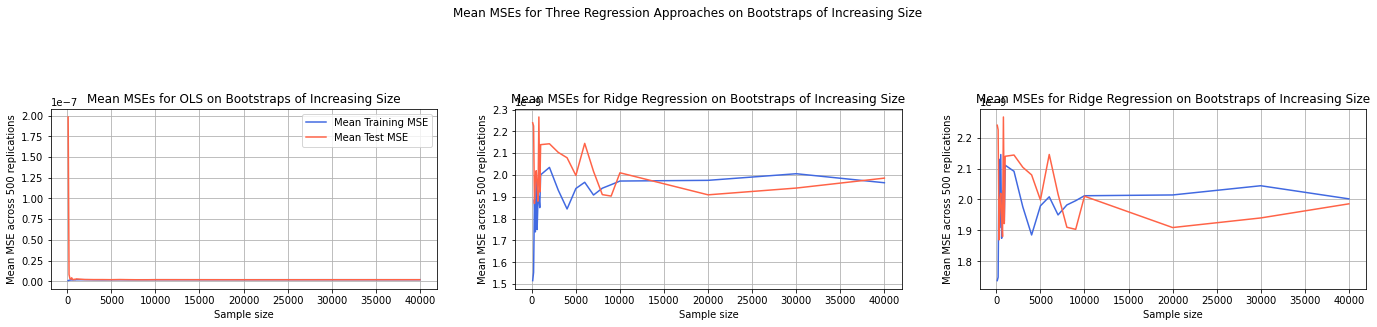

In [202]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
x_sampsize = olsmse[:,0]
y_trainmse = olsmse[:,1]
y_testmse = olsmse[:,2]
plt.plot(x_sampsize, y_trainmse, color = 'royalblue', label = 'Mean Training MSE')
plt.plot(x_sampsize, y_testmse, color = 'tomato', label = 'Mean Test MSE') 
plt.title(r'Mean MSEs for OLS on Bootstraps of Increasing Size') 
plt.xlabel('Sample size') 
plt.ylabel('Mean MSE across 500 replications') 
plt.legend()
plt.grid(True, which='both') 

plt.subplot(1,3,2)

x_sampsize = rmse[:,0]
y_r_trainmse = rmse[:,1]
y_r_testmse = rmse[:,2]
plt.plot(x_sampsize, y_r_trainmse, color = 'royalblue', label = 'Mean Training MSE')
plt.plot(x_sampsize, y_r_testmse, color = 'tomato', label = 'Mean Test MSE') 
plt.title(r'Mean MSEs for Ridge Regression on Bootstraps of Increasing Size') 
plt.xlabel('Sample size') 
plt.ylabel('Mean MSE across 500 replications') 
plt.grid(True, which='both')

plt.subplot(1,3,3) # YOUR CODE HERE

x_sampsize = lmse[:,0]
y_l_trainmse = lmse[:,1]
y_l_testmse = lmse[:,2]
plt.plot(x_sampsize, y_l_trainmse, color = 'royalblue', label = 'Mean Training MSE')
plt.plot(x_sampsize, y_l_testmse, color = 'tomato', label = 'Mean Test MSE') 
plt.title(r'Mean MSEs for Ridge Regression on Bootstraps of Increasing Size') 
plt.xlabel('Sample size') 
plt.ylabel('Mean MSE across 500 replications') 
plt.grid(True, which='both')

plt.suptitle('Mean MSEs for Three Regression Approaches on Bootstraps of Increasing Size')

plt.tight_layout(pad = 4)

plt.show()

In [204]:
ols_minsize = olsmse[olsmse[:,2] < 1.2 * 1.2 * ols_test_mse][0,0]
ridge_minsize = rmse[rmse[:,2] < 1.2 * 1.2 * r_test_mse][0,0]
lasso_minsize = lmse[lmse[:,2] < 1.2 * 1.2 * l_test_mse][0,0]
print(ols_minsize)
print(ridge_minsize)
print(lasso_minsize)

400.0
100.0
100.0


## Interpretation and Conclusions (20 points)
